## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy import constants
import seaborn as sns
import exoplanet as xo
import astropy.units as u
from astropy.timeseries import LombScargle as ls
import lightkurve as lk
from astropy.io import fits


from uncertainties import ufloat
from uncertainties.umath import *
from scipy import constants as c
from scipy import stats

import pymc as pm
import pymc_ext as pmx
import arviz as az
from celerite2.pymc import GaussianProcess, terms
import pytensor.tensor as pt
%matplotlib inline

In [3]:
mpl.rcParams["figure.figsize"] = (6, 4)
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['xtick.direction'] = 'inout'
mpl.rcParams['ytick.direction'] = 'inout'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

mpl.rcParams['font.size'] = SMALL_SIZE          # controls default text sizes
mpl.rcParams['axes.titlesize'] = SMALL_SIZE     # fontsize of the axes title
mpl.rcParams['axes.labelsize'] = MEDIUM_SIZE    # fontsize of the x and y labels
mpl.rcParams['xtick.labelsize'] = SMALL_SIZE    # fontsize of the tick labels
mpl.rcParams['ytick.labelsize'] = SMALL_SIZE    # fontsize of the tick labels
mpl.rcParams['legend.fontsize'] = SMALL_SIZE    # legend fontsize
mpl.rcParams['figure.titlesize'] = BIGGER_SIZE  # fontsize of the figure title

## System parameters

In [4]:
# from exoplanet.eu catalog: https://exoplanet.eu/catalog/lp_714_47_b--7534/#publication_21546
# Dreizler et al 2020: https://www.aanda.org/articles/aa/full_html/2020/12/aa38016-20/aa38016-20.html
# exofop: https://exofop.ipac.caltech.edu/tess/target.php?id=70899085
TIC_ID = 70899085

epoch_tess = ufloat(2459196.115341, 0.0005086)
period_tess = ufloat(4.0520368, 0.0000044)
duration_tess = 1.5605127851947
strad_tess = ufloat(0.607, 0.018)
stmass_tess = ufloat(0.594, 0.020)
stteff_tess = ufloat(3779, 157)

mass_pub = ufloat(0.0969, 0.0047)*u.M_jup.to(u.M_earth)
period_pub = ufloat(4.052037, 4e-06) # days
e_pub = ufloat(0.04, 0.02)
K_pub = ufloat(17.6, 0.8) # m/s
epoch_pub = ufloat(0.38421+58438, 0.00025)
radius_pub = ufloat(4.7, 0.3) # R_earth

stteff_pub = ufloat(3950, 51)
strad_pub = ufloat(0.584, 0.016)
stmass_pub = ufloat(0.59, 0.02)

## Read RVs

In [5]:
spirou_lbl2 = pd.read_table('./data/toi442/lbl2_TOI442_GL846_sep24.rdb', sep=None, engine='python', header=0)
spirou_lbl = pd.read_table('./data/toi442/lbl_TOI442_GL846_sep24.rdb', sep=None, engine='python', header=0)
spirou_lbl2_star = pd.read_table('./data/toi442/lbl2_TOI442_TOI442_sep24.rdb', sep=None, engine='python', header=0)
spirou_lbl_star = pd.read_table('./data/toi442/lbl_TOI442_TOI442_sep24.rdb', sep=None, engine='python', header=0)
others = pd.read_table('./data/toi442/other_instruments.rdb', sep='\s+', engine='python', header=0)

# substract 2400000 to the BJD time of the other instruments
others['BJD'] = others['BJD'] - 2400000
others.drop('id', axis=1, inplace=True)
# change the name of the column to match the SPIROU data
others = others.rename(columns={'RV': 'vrad', 'e': 'svrad', 'BJD': 'rjd', 'Inst': 'inst'})    
rv_inst_names = ['SPIROU', 'CARMENES-VIS', 'CARMENES-NIR', 
                 'ESPRESSO', 'HIRES', 'iSHELL', 'PFS']
star_name = 'TOI-442'
print(len(spirou_lbl2), len(spirou_lbl))
print(len(spirou_lbl2_star), len(spirou_lbl_star))

14 56
14 56


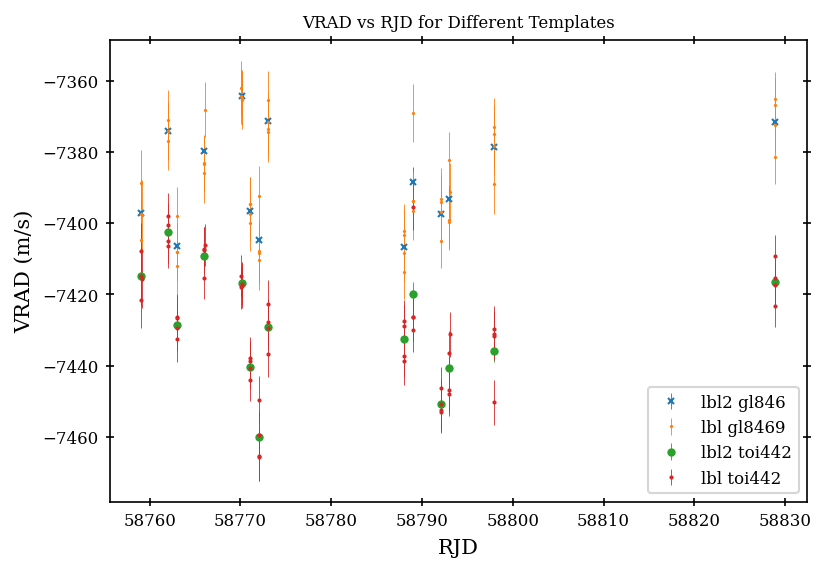

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot the vrad vs rjd for each template
ax.errorbar(spirou_lbl2.rjd, spirou_lbl2.vrad, yerr=spirou_lbl2.svrad, fmt='x', label='lbl2 gl846', markersize=3, elinewidth=0.4)
ax.errorbar(spirou_lbl.rjd, spirou_lbl.vrad, yerr=spirou_lbl.svrad, fmt='x', label='lbl gl8469', markersize=1, elinewidth=0.4)
ax.errorbar(spirou_lbl2_star.rjd, spirou_lbl2_star.vrad, yerr=spirou_lbl2_star.svrad, fmt='o', label='lbl2 toi442', markersize=3, elinewidth=0.4)
ax.errorbar(spirou_lbl_star.rjd, spirou_lbl_star.vrad, yerr=spirou_lbl_star.svrad, fmt='o', label='lbl toi442', markersize=1, elinewidth=0.4)

ax.set_xlabel('RJD')
ax.set_ylabel('VRAD (m/s)')
ax.set_title('VRAD vs RJD for Different Templates')
ax.legend()
plt.show()

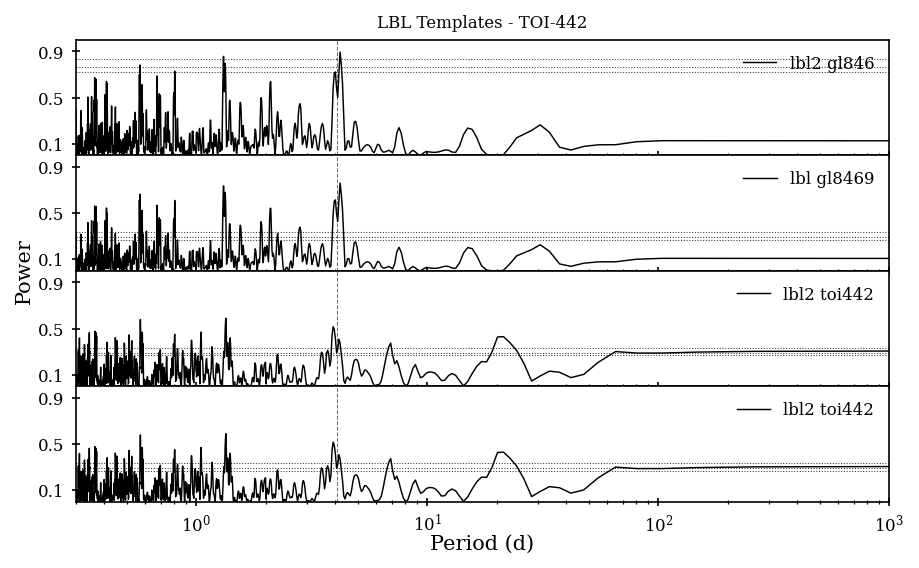

In [7]:
# check if the signal is present in any of the datasets
series = ['lbl2 gl846', 'lbl gl8469', 'lbl2 toi442', 'lbl2 toi442']

lg = [ls(spirou_lbl2.rjd, spirou_lbl2.vrad, spirou_lbl2.svrad),
      ls(spirou_lbl.rjd, spirou_lbl.vrad, spirou_lbl.svrad),
      ls(spirou_lbl2_star.rjd, spirou_lbl2_star.vrad, spirou_lbl2_star.svrad),
      ls(spirou_lbl_star.rjd, spirou_lbl_star.vrad, spirou_lbl_star.svrad)]

min_freq = 0.001
max_freq = 10
sppk = 5
probabilities = [0.1, 0.05, 0.01]

freq = {}
power = {}
fap = {}

for n, name in enumerate(series):
    freq[name], power[name] = lg[n].autopower(minimum_frequency=min_freq, maximum_frequency=max_freq, samples_per_peak=sppk)
    fap[name] = lg[n].false_alarm_level(probabilities)

# plot the periodograms
fig, ax = plt.subplots(len(series), 1, sharex=True, figsize=(7,4), dpi=150)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)

for i, name in enumerate(series):
    ax[i].axvline(x=period_tess.nominal_value, color='r', linestyle='--', linewidth=0.5, alpha=0.8)
    ax[i].plot(1/freq[series[i]], power[series[i]], color='k', linewidth=0.7, label=name)
    ax[i].set_ylabel(series[i])
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(0.3, 1000)
    ax[i].set_xscale('log')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].legend(frameon=False, markerscale=0, loc='upper right')
    ax[i].set_yticks([0.1, 0.5, 0.9])
    ax[i].tick_params(which='both', top=False, right=False)
    ax[i].axhline(y=fap[name][0], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                  , label=f'FAP {probabilities[0]*100}%', zorder=0)
    ax[i].axhline(y=fap[name][1], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                    , label=f'FAP {probabilities[1]*100}%', zorder=0)
    ax[i].axhline(y=fap[name][2], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                    , label=f'FAP {probabilities[2]*100}%', zorder=0)
    
# add a big axis, hide frame
bigax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
bigax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
bigax.set_xlabel("Period (d)", labelpad=2)
bigax.set_ylabel("Power", labelpad=2)
bigax.set_title(f'LBL Templates - {star_name}')
plt.savefig(f'./plots/toi442/periodograms-by-reduction-template{star_name}.png', dpi=200, facecolor='w', bbox_inches='tight')

In [118]:
others.inst.unique()

array(['CARMENES-VIS', 'CARMENES-NIR', 'ESPRESSO', 'HIRES', 'iSHELL',
       'PFS'], dtype=object)

In [119]:
# d2v is "differential line width", an activity indicator. 
# d3v is then the column linked to the third derivative, it is supposed to be linked to the asymmetry of the line, 
# but as far as I know no one tries to use that product yet

# define the spirou data to use
spirou = spirou_lbl2.copy()
spirou.head()

,rjd,vrad,svrad,d2v,sd2v,d3v,sd3v,local_file_name,plot_date,dW,...,vrad_2080nm,svrad_2080nm,vrad_2167nm,svrad_2167nm,vrad_2257nm,svrad_2257nm,vrad_2351nm,svrad_2351nm,vrad_2449nm,svrad_2449nm
0,58759.099352,-7397.056429,4.791139,-99263.497653,11644.229235,-5.102270e+07,2.153491e+07,2446035o_pp_e2dsff_tcorr_AB_TOI442_GL846_lbl.fits,18171.591738,-5.504337e+05,...,-7332.886397,27.557326,-7398.521960,39.073341,-7533.328489,31.390904,-7414.073774,16.080845,-7378.426394,34.101821
1,58761.991347,-7374.058768,4.004270,266349.639006,9800.822834,-3.408132e+07,1.811593e+07,2446427o_pp_e2dsff_tcorr_AB_TOI442_GL846_lbl.fits,18174.483542,1.476956e+06,...,-7339.096117,24.722595,-7525.564670,34.733570,-7465.579766,25.464413,-7390.713345,13.336327,-7388.354465,27.433725
2,58762.982476,-7406.452477,4.048727,-137604.963106,9870.734210,-4.219595e+07,1.823598e+07,2446609o_pp_e2dsff_tcorr_AB_TOI442_GL846_lbl.fits,18175.474610,-7.630439e+05,...,-7374.703480,25.813091,-7450.803841,35.681725,-7398.337727,25.876885,-7413.938904,13.314013,-7378.851492,27.772346
3,58766.039346,-7379.743134,3.960176,269909.006920,9723.162864,-3.373430e+07,1.798324e+07,2447239o_pp_e2dsff_tcorr_AB_TOI442_GL846_lbl.fits,18178.531309,1.496693e+06,...,-7328.603792,27.315696,-7473.612060,39.272133,-7420.521746,26.299848,-7405.232991,14.143986,-7361.538647,28.903161
4,58770.122279,-7364.167764,3.919292,285230.149841,9605.214471,-4.389580e+07,1.779629e+07,2447827o_pp_e2dsff_tcorr_AB_TOI442_GL846_lbl.fits,18182.614029,1.581652e+06,...,-7316.600562,25.338153,-7500.274182,36.295045,-7359.992039,26.988041,-7370.126919,14.486527,-7296.533434,32.479495


### Outliers

Text(0.5, 0, 'RV [km/s]')

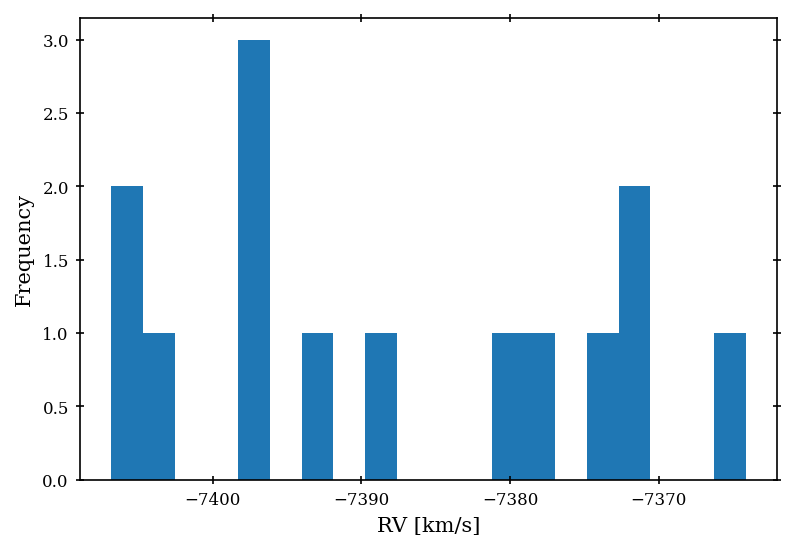

In [120]:
# histograma
spirou.vrad.plot(kind='hist', bins=20)
plt.xlabel('RV [km/s]')

<Axes: >

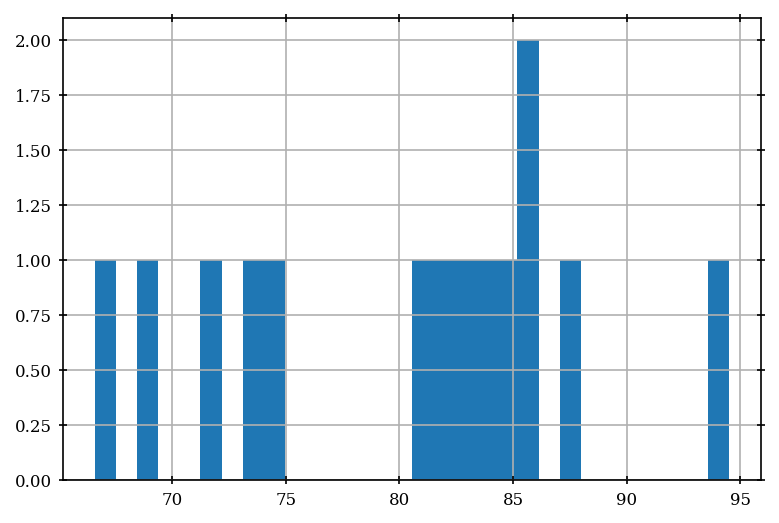

In [121]:
# remove low SNR points
spirou['EXTSN035'].hist(bins=30)

<Axes: >

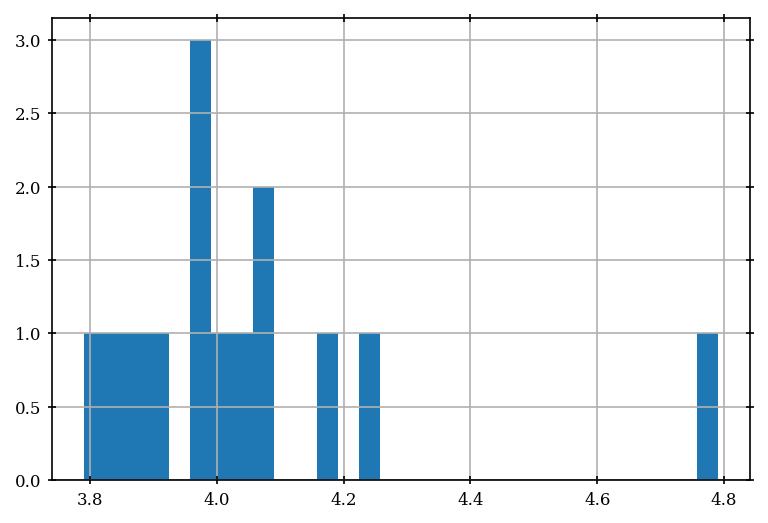

In [122]:
# remove low SNR points
spirou['svrad'].hist(bins=30)

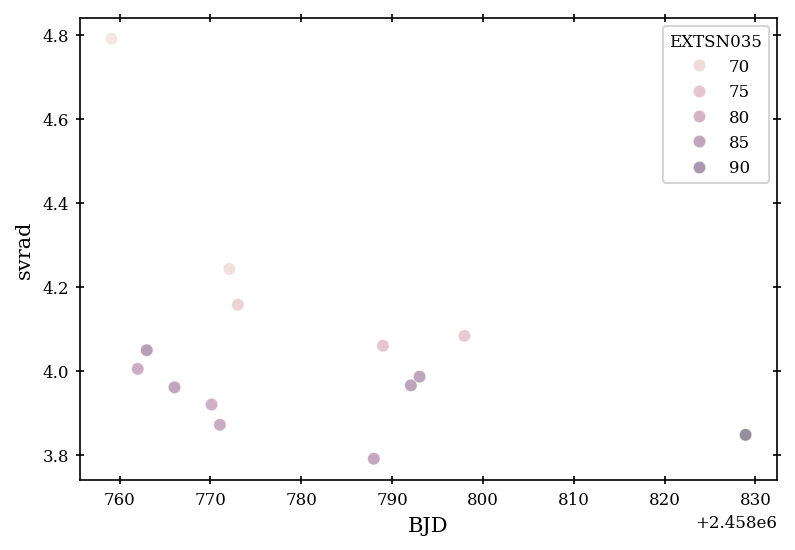

In [123]:
sns.scatterplot(data=spirou, x='BJD', y='svrad', hue='EXTSN035', alpha=0.5)
plt.show()

<Axes: ylabel='Frequency'>

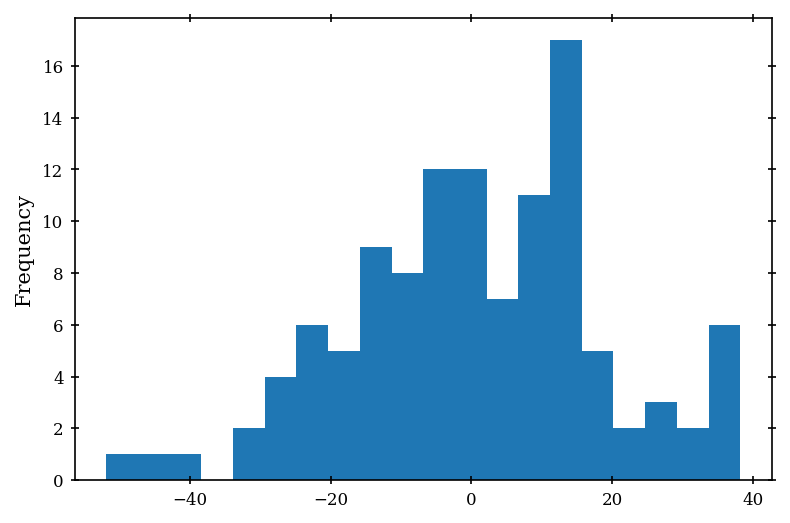

In [124]:
others.vrad.plot(kind='hist', bins=20)

<Axes: >

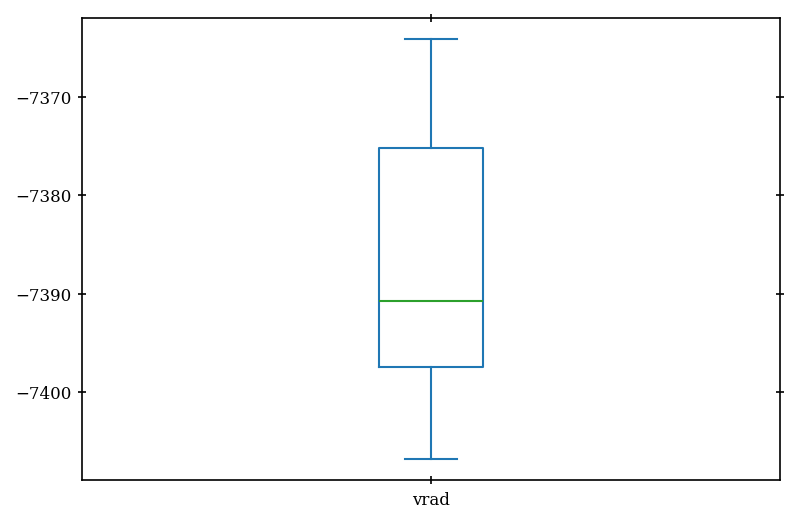

In [125]:
# boxplot
spirou.vrad.plot(kind='box')

<Axes: >

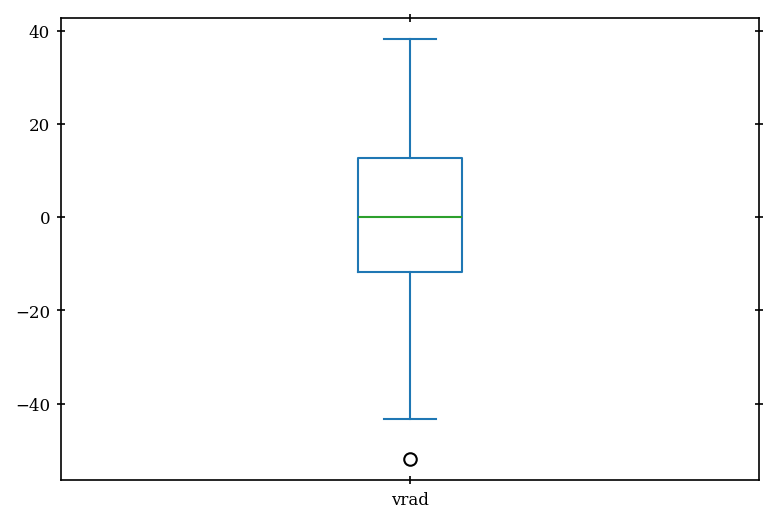

In [126]:
others.vrad.plot(kind='box')

In [127]:
# # detect outliers using iqr
# q1 = spirou.vrad.quantile(0.25)
# q3 = spirou.vrad.quantile(0.75)
# iqr = q3 - q1
# mask = (spirou.vrad < (q1 - 1.5 * iqr)) | (spirou.vrad > (q3 + 1.5 * iqr))

# # filter outliers
# spirou = spirou[~mask]

# substract the median of the radial velocity
spirou['vrad'] = spirou['vrad'] - spirou['vrad'].median()

# the other instruments are already centered

### Plot RVs

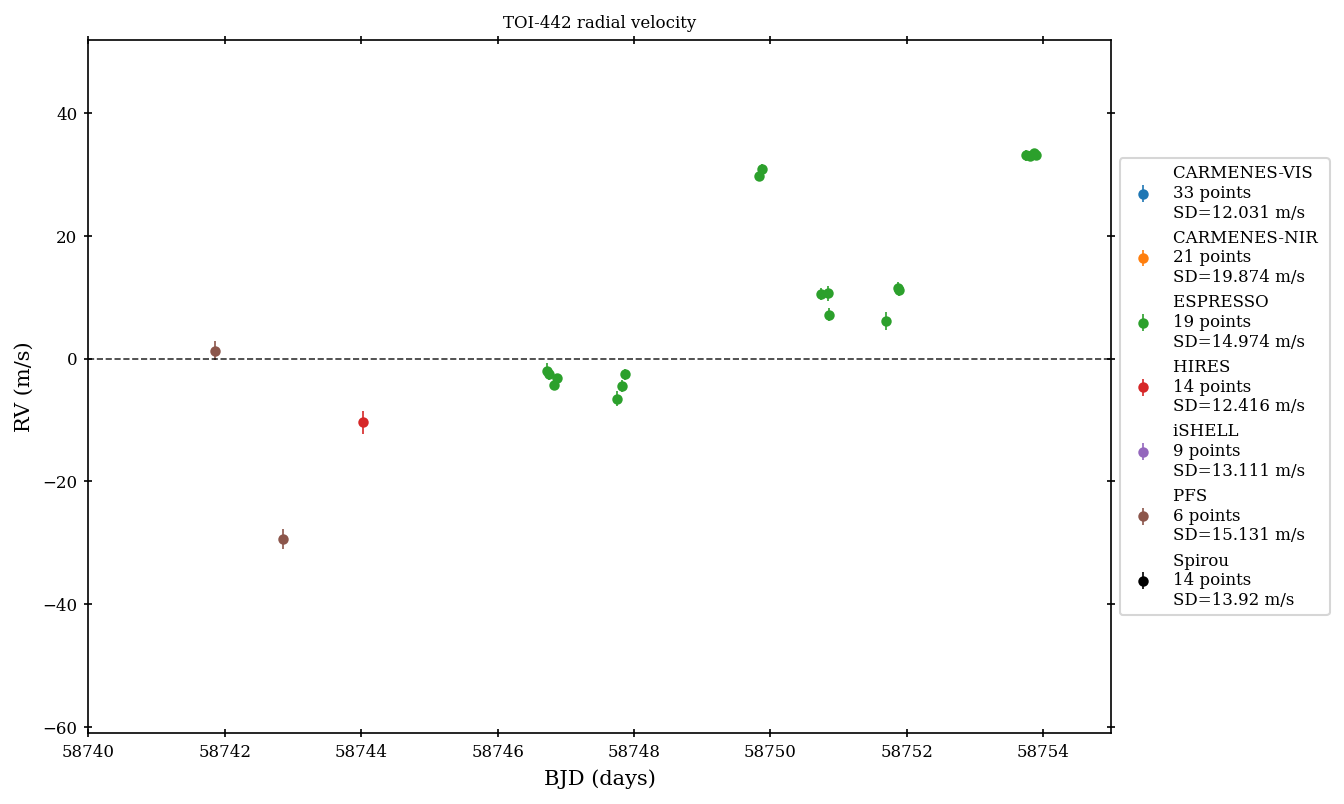

In [322]:
fig, ax = plt.subplots(figsize=(11, 6))

for inst in others.inst.unique():
    mask = others.inst == inst
    ax.errorbar(others[mask].rjd, others[mask].vrad-others.vrad.median(), yerr=others[mask].svrad, fmt='o', label=f'{inst} \n{len(others[mask])} points\nSD={np.round(np.std(others[mask].vrad),3)} m/s', markersize=4, elinewidth=0.8)
ax.errorbar(spirou['rjd'], spirou['vrad'], yerr=spirou['svrad'], fmt='o', label=f'Spirou \n{len(spirou)} points\nSD={np.round(np.std(spirou.vrad),3)} m/s', markersize=4, elinewidth=0.8, color='k')
ax.axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.8)
# set legend outside the plot
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title(f'{star_name} radial velocity')
ax.set_xlabel('BJD (days)')
ax.set_xlim(58740, 58755)
ax.set_ylabel('RV (m/s)')
#plt.savefig(f'./plots/toi442/all_rvs_{star_name}.png', dpi=200, facecolor='w', bbox_inches='tight')
plt.show()

In [129]:
# drop the first season of CARMENES-NIR
mask = (others.inst == 'CARMENES-NIR') & (others.rjd < 58600)
others = others[~mask]

In [130]:
others.inst.unique()

array(['CARMENES-VIS', 'CARMENES-NIR', 'ESPRESSO', 'HIRES', 'iSHELL',
       'PFS'], dtype=object)

In [131]:
spirou['inst'] = 'SPIROU'
# prepare the data for the model
x_rv = np.concatenate((spirou['rjd'], others['rjd']))
y_rv = np.concatenate((spirou['vrad'], others['vrad']))
yerr_rv = np.concatenate((spirou['svrad'], others['svrad']))
rv_inst = np.concatenate((spirou['inst'], others['inst']))
# map inst names to integers
rv_inst_id = np.array([rv_inst_names.index(inst) for inst in rv_inst])

inds = np.argsort(x_rv)
x_rv = np.ascontiguousarray(x_rv[inds], dtype=np.float64) - 57000
y_rv = np.ascontiguousarray(y_rv[inds], dtype=np.float64)
yerr_rv = np.ascontiguousarray(yerr_rv[inds], dtype=np.float64)
rv_inst_id = np.ascontiguousarray(rv_inst_id[inds], dtype=int)
rv_inst = np.ascontiguousarray(rv_inst[inds], dtype='S')

num_rv_inst = len(rv_inst_names)

In [132]:
np.unique(rv_inst) 

array([b'CARMENES-NIR', b'CARMENES-VIS', b'ESPRESSO', b'HIRES', b'PFS',
       b'SPIROU', b'iSHELL'], dtype='|S12')

In [133]:
others.groupby('inst')['rjd'].count()

inst
CARMENES-NIR    21
CARMENES-VIS    33
ESPRESSO        19
HIRES           14
PFS              6
iSHELL           9
Name: rjd, dtype: int64

### GLS analysis

In [134]:
series = ['spirou rvs', 'spirou dlw',  'carmenes-nir', 'carmenes-vis', 'espresso', 'hires', 'ishell', 'all rvs', 'window function']
carmenes_nir_mask = rv_inst == b'CARMENES-NIR'
carmenes_vis_mask = rv_inst == b'CARMENES-VIS'
espresso_mask = rv_inst == b'ESPRESSO'
hires_mask = rv_inst == b'HIRES'
ishell_mask = rv_inst == b'iSHELL'

lg = [ls(spirou.rjd, spirou.vrad, spirou.svrad),
      ls(spirou.rjd, spirou.d2v, spirou.sd2v),
      ls(x_rv[carmenes_nir_mask], y_rv[carmenes_nir_mask], yerr_rv[carmenes_nir_mask]),
      ls(x_rv[carmenes_vis_mask], y_rv[carmenes_vis_mask], yerr_rv[carmenes_vis_mask]),
      ls(x_rv[espresso_mask], y_rv[espresso_mask], yerr_rv[espresso_mask]),
      ls(x_rv[hires_mask], y_rv[hires_mask], yerr_rv[hires_mask]),
      ls(x_rv[ishell_mask], y_rv[ishell_mask], yerr_rv[ishell_mask]),
      ls(x_rv, y_rv, yerr_rv),
      ls(x_rv, np.ones(len(x_rv)), fit_mean=False, center_data=False)]

min_freq = 0.001
max_freq = 10
sppk = 5
probabilities = [0.1, 0.05, 0.01]

freq = {}
power = {}
fap = {}

for n, name in enumerate(series):
    freq[name], power[name] = lg[n].autopower(minimum_frequency=min_freq, maximum_frequency=max_freq, samples_per_peak=sppk)
    if name != 'window function':
        fap[name] = lg[n].false_alarm_level(probabilities)

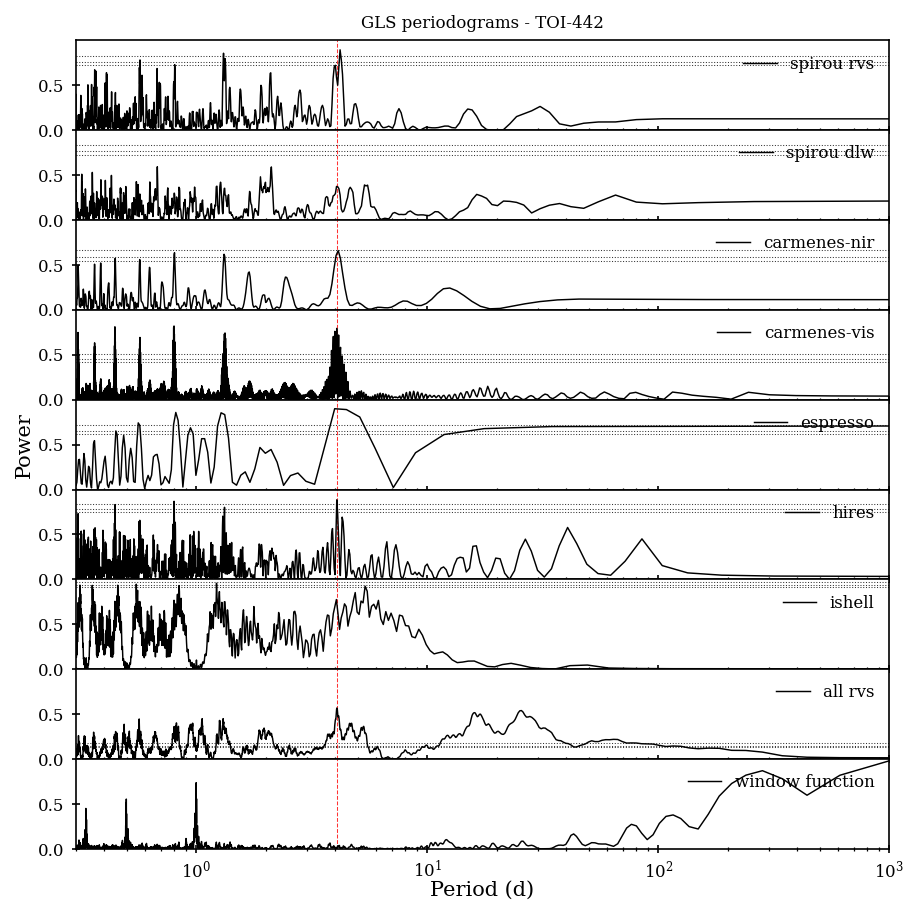

In [135]:
# plot the periodograms
fig, ax = plt.subplots(len(series), 1, sharex=True, figsize=(7,7), dpi=150)
#fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)

for i, name in enumerate(series):
    ax[i].axvline(x=period_tess.nominal_value, color='r', linestyle='--', linewidth=0.5, alpha=0.8)
    ax[i].plot(1/freq[series[i]], power[series[i]], color='k', linewidth=0.7, label=name)
    ax[i].set_ylabel(series[i])
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(0.3, 1000)
    ax[i].set_xscale('log')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].legend(frameon=False, markerscale=0, loc='upper right')
    ax[i].set_yticks([0.0, 0.5])
    ax[i].tick_params(which='both', top=False, right=False)
    if name == "window function":
        ax[i].set_ylim(0, 1)
        ax[i].set_yticks([0.0, 0.5])
    else:
        ax[i].axhline(y=fap[name][0], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                  , label=f'FAP {probabilities[0]*100}%', zorder=0)
        ax[i].axhline(y=fap[name][1], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                    , label=f'FAP {probabilities[1]*100}%', zorder=0)
        ax[i].axhline(y=fap[name][2], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                    , label=f'FAP {probabilities[2]*100}%', zorder=0)
    
# add a big axis, hide frame
bigax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
bigax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
bigax.set_xlabel("Period (d)", labelpad=2)
bigax.set_ylabel("Power", labelpad=2)
bigax.set_title(f'GLS periodograms - {star_name}')
plt.savefig(f'./plots/toi442/rv_periodograms_{star_name}.png', dpi=200, facecolor='w', bbox_inches='tight')

## Read LCs

In [136]:
#exofop: https://exofop.ipac.caltech.edu/tess/target.php?id=70899085

In [137]:
lk.search_targetpixelfile('TIC 70899085')

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 05,2018,SPOC,120,70899085,0.0
1,TESS Sector 32,2020,SPOC,120,70899085,0.0
2,TESS Sector 05,2018,TESS-SPOC,1800,70899085,0.0
3,TESS Sector 32,2020,TESS-SPOC,600,70899085,0.0


In [138]:
search = lk.search_lightcurve('TIC 70899085')
search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 05,2018,SPOC,120,70899085,0.0
1,TESS Sector 32,2020,SPOC,120,70899085,0.0
2,TESS Sector 05,2018,TESS-SPOC,1800,70899085,0.0
3,TESS Sector 32,2020,TESS-SPOC,600,70899085,0.0
4,TESS Sector 05,2018,QLP,1800,70899085,0.0
5,TESS Sector 32,2020,QLP,600,70899085,0.0
6,TESS Sector 05,2018,TASOC,120,70899085,0.0
7,TESS Sector,2018,DIAMANTE,1800,70899085,0.0
8,TESS Sector 05,2018,GSFC-ELEANOR-LITE,1800,70899085,0.0


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

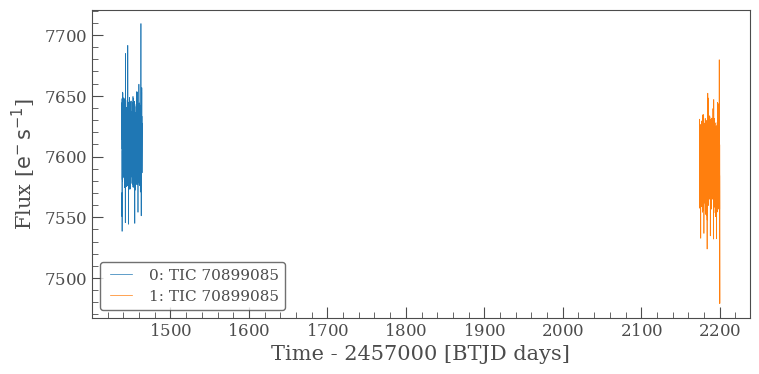

In [139]:
search[search.author == 'SPOC'].download_all().plot()

In [140]:
# download both sectors and stitch them together
lc_file = lk.search_lightcurve('TIC 70899085', author='SPOC', exptime=120).download_all(flux_column="pdcsap_flux")
lc = lc_file.stitch().remove_nans().normalize().remove_outliers()

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

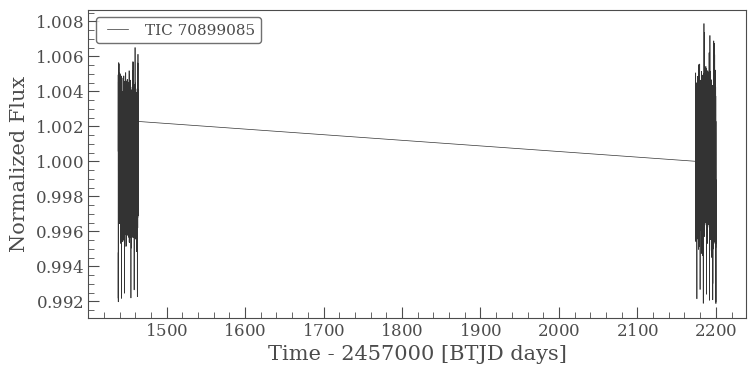

In [141]:
lc.plot()

(1437.0, 1464.0)

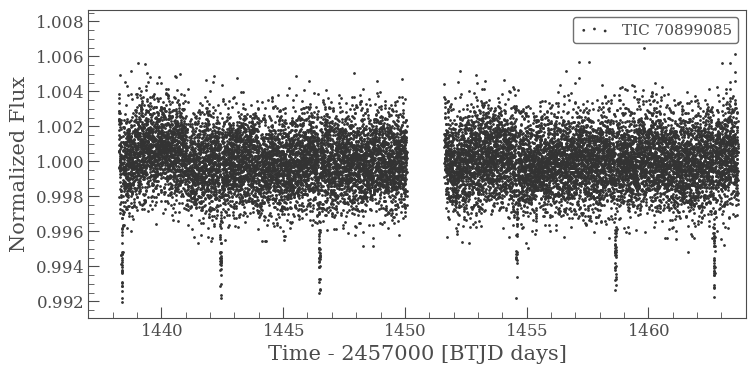

In [142]:
# sector 5
lc.scatter()
plt.xlim(1437, 1464)

(2172.0, 2201.0)

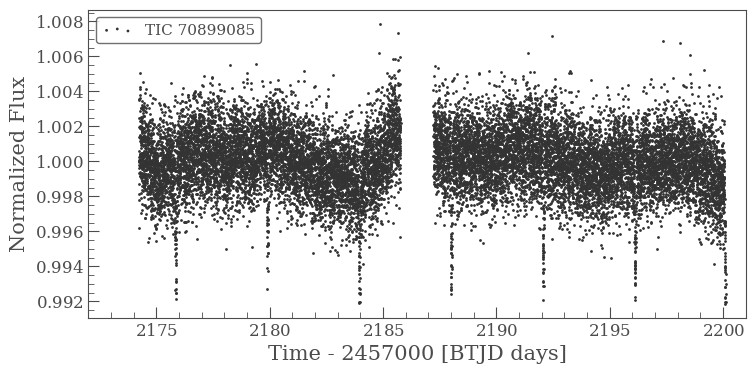

In [143]:
# sector 32
lc.scatter()
plt.xlim(2172, 2201)

In [144]:
# lets remove that last transit
lc = lc.truncate(after=2199.50)

<Axes: xlabel='Phase [JD]', ylabel='Normalized Flux'>

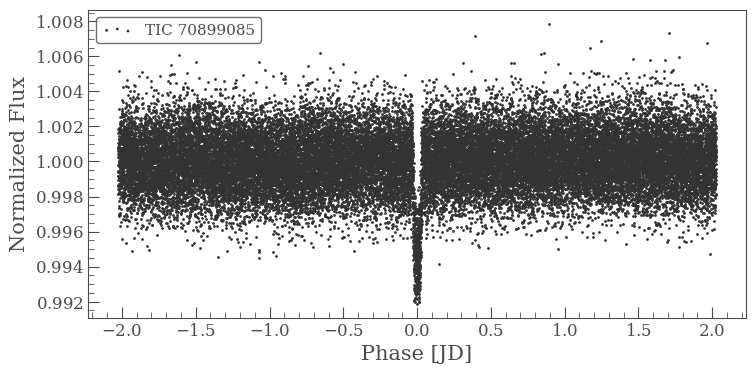

In [145]:
lc.fold(period_tess.nominal_value, epoch_time=epoch_tess.nominal_value-2457000).scatter()

In [146]:
# lets bin to 5 min for faster computation
lc_binned = lc.bin(time_bin_size=5*u.min.to(u.day)).remove_nans()

time = lc.time.value
flux = lc.flux.value
flux_err = lc.flux_err.value
inds = np.argsort(time)
time = np.ascontiguousarray(time[inds], dtype=np.float64)
flux = np.ascontiguousarray(flux[inds], dtype=np.float64)
flux_err = np.ascontiguousarray(flux_err[inds], dtype=np.float64)

time_5min = lc_binned.time.value
flux_5min = lc_binned.flux.value
flux_err_5min = lc_binned.flux_err.value
inds5 = np.argsort(time_5min)
time_5min = np.ascontiguousarray(time_5min[inds5], dtype=np.float64)
flux_5min = np.ascontiguousarray(flux_5min[inds5], dtype=np.float64)
flux_err_5min = np.ascontiguousarray(flux_err_5min[inds5], dtype=np.float64)



# get the exptimes
texp = 2.0 / 60.0 / 24.0
texp_binned = 5.0 / 60.0 / 24.0

ref_time = np.min(time)

In [147]:
# we're gonna split the lightcurves in 2 parts, sector 5, and sector 32
# lets creat another variable to store the sector of each point, then the sector ID will be 0, 1
# same as we did with different instruments in RVs
# sector 5 -> time < 1800
# sector 32 -> 1800 < time 

# 2min cadence
sector_id = np.zeros(len(time), dtype=int)
sector_id[time < 1800] = 0
sector_id[time > 1800] = 1

# 5min cadence
sector_id_5min = np.zeros(len(time_5min), dtype=int)
sector_id_5min[time_5min < 1800] = 0
sector_id_5min[time_5min > 1800] = 1

sector_id_names = ['Sector_5', 'Sector_32']

### TESS TLS

In [148]:
from transitleastsquares import (
    transitleastsquares,
    cleaned_array,
    catalog_info,
    transit_mask
    )

In [149]:
# lets recover first the planet detected by TESS 
tls_time, tls_flux, tls_flux_err = cleaned_array(lc.time.value, lc.flux, lc.flux_err)

# catalog_info: ab, mass, mass_min, mass_max, radius, radius_min, radius_max
info = catalog_info(TIC_ID=TIC_ID) # to put priors on search
tls = transitleastsquares(tls_time, tls_flux, tls_flux_err)
results = tls.power(R_star=float(info[4]), R_star_min=info[4]-info[5], R_star_max=info[4]+info[6],
                   M_star=float(info[1]), M_star_min=info[1]-info[2], M_star_max=info[1]+info[3],
                   u=list(info[0]), period_min=period_tess.nominal_value-0.1, period_max=period_tess.nominal_value+0.1)

Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 29 durations
Searching 34136 data points, 1294 periods from 3.952 to 4.152 days
Using all 12 CPU threads


100%|██████████| 1294/1294 periods | 00:09<00:00


Searching for best T0 for period 4.05209 days


/home/juan/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/juan/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/juan/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/juan/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/transitleastsquares/main.py:411: UserWarning: 176 of 188 transits without data. The true period may be twice the given period.
  warnings.warn(text)


In [150]:
print(results.period, results.T0, results.duration, results.depth, results.SDE)

4.052089741155009 1438.3798137556603 0.005362209447688024 0.9965502210912637 17.33819836391155


### Transit masks

(1437.0, 1464.0)

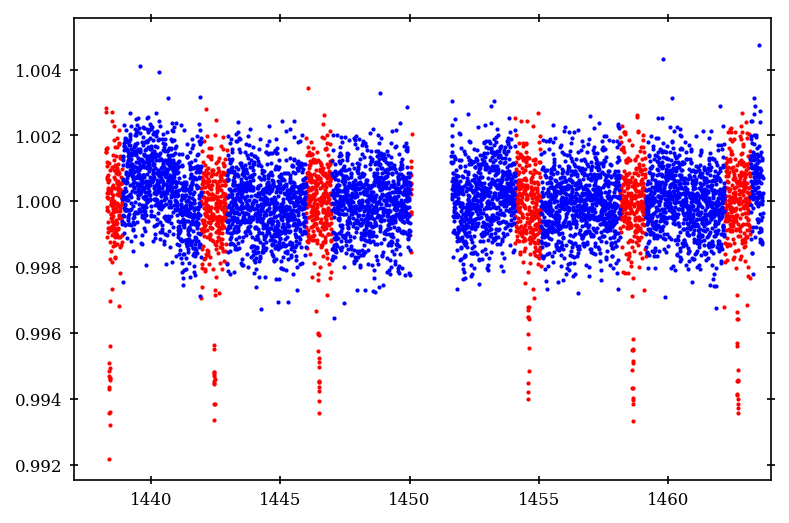

In [151]:
intransit_5min = transit_mask(time_5min, results.period, 1, results.T0)
intransit = transit_mask(time, results.period, 1, results.T0)

plt.scatter(time_5min[intransit_5min], flux_5min[intransit_5min], s=1, color='red')  # in-transit points in red
plt.scatter(time_5min[~intransit_5min], flux_5min[~intransit_5min], s=1, color='blue')  # other points in blue
plt.xlim(1437, 1464)

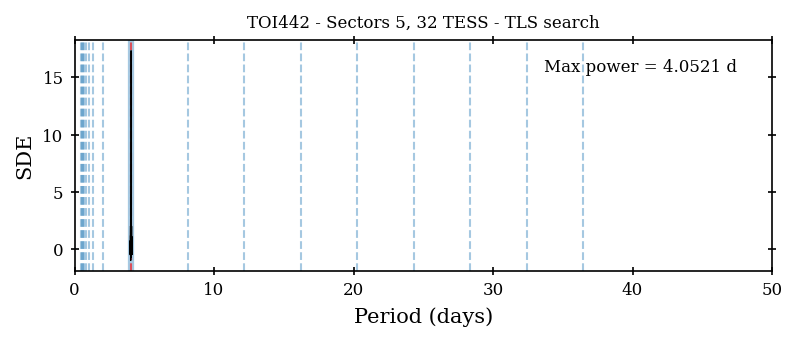

In [152]:
plt.figure(figsize=(6, 2))
ax = plt.gca()
ax.axvline(results.period, alpha=0.4, lw=3)
ax.axvline(period_tess.nominal_value, ls='--', alpha=0.6, lw=1, color='red')
plt.xlim(np.min(results.periods), np.max(results.periods))
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power, color='black', lw=0.5)
plt.xlim(0, 50)
plt.text(.95, .92, 'Max power = {k:.4f} d'.format(k=results.period), fontsize=8, 
         ha='right', va='top', transform=ax.transAxes)
plt.title('TOI442 - Sectors 5, 32 TESS - TLS search')
plt.savefig(f'./plots/toi442/tls1-{star_name}.png', dpi=200, bbox_inches='tight', pad_inches=0.1)

Text(0, 0.5, 'Relative flux')

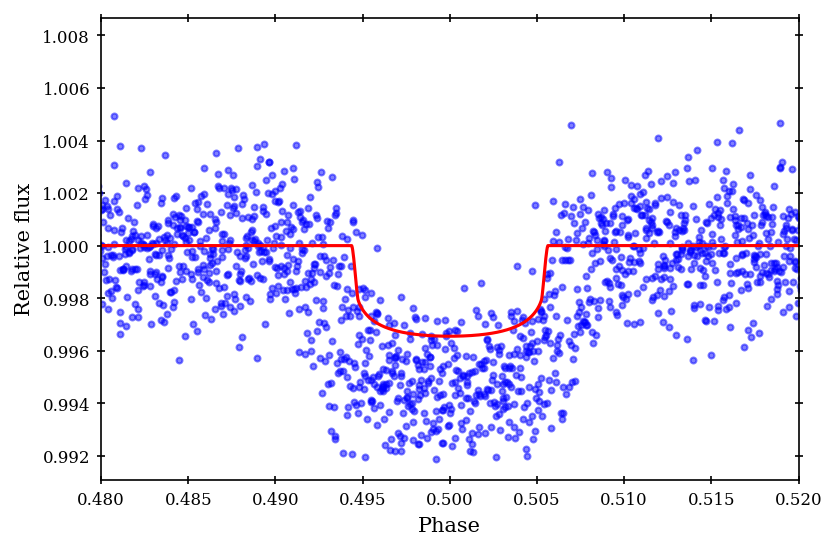

In [153]:
# results phase folded
plt.figure()
plt.scatter(results.folded_phase, results.folded_y, color='blue', s=8, alpha=0.5, zorder=2)
plt.plot(results.model_folded_phase, results.model_folded_model, color='red')
plt.xlim(0.48, 0.52)
plt.xlabel('Phase')
plt.ylabel('Relative flux')

In [154]:
results.duration*12

0.06434651337225629

In [155]:
duration_tess/24

0.06502136604977916

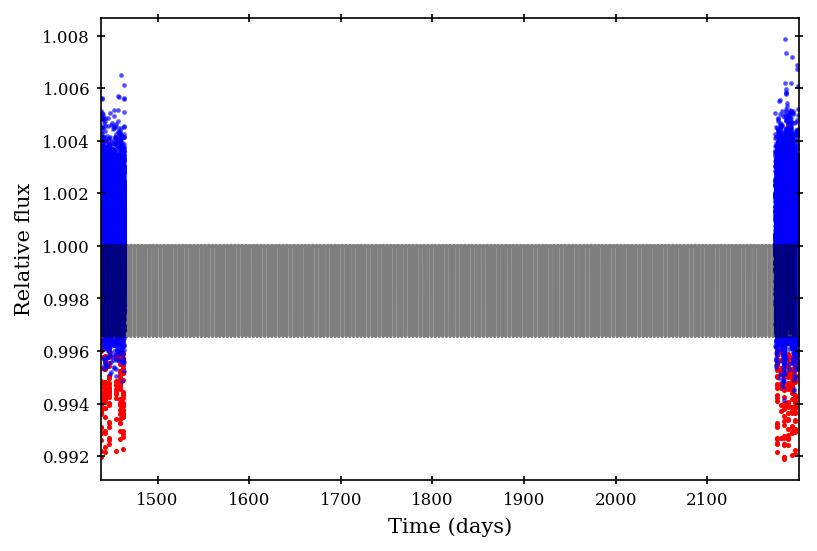

In [156]:
# complete light curve
plt.figure()
in_transit = transit_mask(lc.time.value, results.period, results.duration*20, results.T0)
plt.scatter(lc.time.value[in_transit], lc.flux[in_transit], color='red', s=2, zorder=0)
plt.scatter(lc.time.value[~in_transit], lc.flux[~in_transit], color='blue', alpha=0.5, s=2, zorder=0)
plt.plot(results.model_lightcurve_time, results.model_lightcurve_model, alpha=0.5, color='k', zorder=1)
plt.xlim(lc.time.value.min(), lc.time.value.max())
plt.xlabel('Time (days)')
plt.ylabel('Relative flux');
#plt.xlim(1454,1455)

Period 4.05209 d at T0= 1438.3798137556603
The number of transits with intransit data points 12
The number of transits with no intransit data points 176
Transit depth 0.99655 (at the transit bottom)
Transit duration (hours) 0.12869
Transit depths (mean) 5.346520493427875 ppt


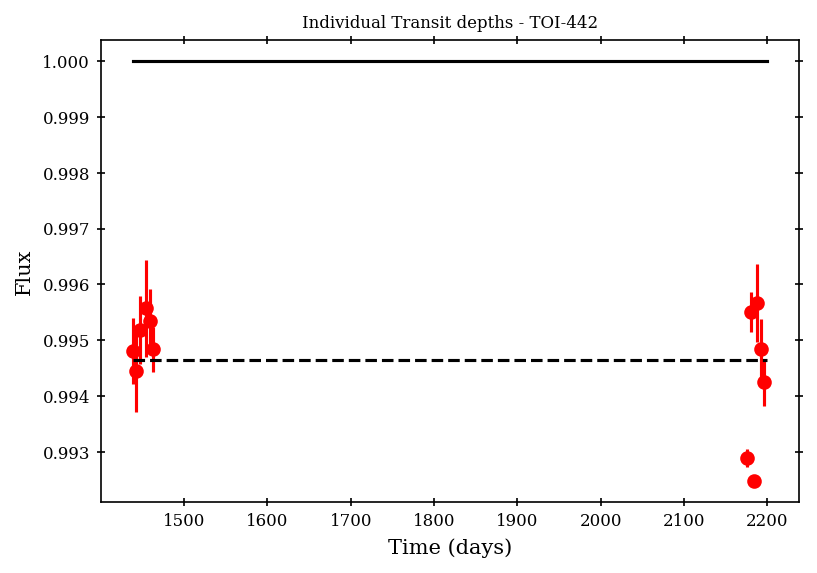

In [157]:
print('Period', format(results.period, '.5f'), 'd at T0=', results.T0)
# print(len(results.transit_times), 'transit times in time series:', ['{0:0.5f}'.format(i) for i in results.transit_times])
# print('Number of data points during each unique transit', results.per_transit_count)
print('The number of transits with intransit data points', results.distinct_transit_count)
print('The number of transits with no intransit data points', results.empty_transit_count)
print('Transit depth', format(results.depth, '.5f'), '(at the transit bottom)')
print('Transit duration (hours)', format(results.duration*24, '.5f'))
print('Transit depths (mean)', (1-np.nanmean(results.transit_depths))*1e3, 'ppt')

plt.figure()
plt.errorbar(
    results.transit_times,
    results.transit_depths,
    yerr=results.transit_depths_uncertainties,
    fmt='o', color='red')
plt.plot(
    (time.min(), time.max()),
    (np.nanmean(results.transit_depths), np.nanmean(results.transit_depths, dtype=np.float64)),
     color='black', linestyle='dashed')
plt.plot((time.min(), time.max()), (1, 1), color='black')
plt.xlabel('Time (days)')
plt.ylabel('Flux');
plt.title(f'Individual Transit depths - {star_name}')
plt.savefig(f'./plots/toi442/transit_depths_{star_name}.png', dpi=200, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [158]:
# # search for second planet
# tls_time_2 = tls_time[~in_transit]
# tls_flux_2 = tls_flux[~in_transit]
# tls_flux_err_2 = tls_flux_err[~in_transit]

# tls_2 = transitleastsquares(tls_time_2, tls_flux_2, tls_flux_err_2)
# results2 = tls_2.power(R_star=float(info[4]), R_star_min=info[4]-info[5], R_star_max=info[4]+info[6],
#                                                 M_star=float(info[1]), M_star_min=info[1]-info[2], M_star_max=info[1]+info[3],
#                                                 period_min=0.5,
#                                                 period_max=(tls_time_2.max()-tls_time_2.min())/2,
#                                                 u=list(info[0]))

In [159]:
# print(results2.period, results2.T0, results2.duration, results2.depth, results2.SDE)

In [160]:
# print(results2.period, results2.T0, results2.duration, results2.depth, results2.SDE)
# # full search 2: 26.16385372279952 1450.5808999733417 0.06890292441317561 0.9988451561346696 11.374034403312262
# # only two transits, one in a border of the sector. it's nothing.

In [161]:
# # complete light curve
# plt.figure()
# in_transit2 = transit_mask(lc.time.value[~in_transit], results2.period, results2.duration*20, results2.T0)
# plt.scatter(lc.time.value[~in_transit][in_transit2], lc.flux[~in_transit][in_transit2], color='red', s=2, zorder=0)
# plt.scatter(lc.time.value[~in_transit][~in_transit2], lc.flux[~in_transit][~in_transit2], color='blue', alpha=0.5, s=2, zorder=0)
# plt.plot(results2.model_lightcurve_time, results2.model_lightcurve_model, alpha=0.5, color='k', zorder=1)
# plt.xlim(lc.time.value[~in_transit].min(), lc.time.value[~in_transit].max())
# plt.xlabel('Time (days)')
# plt.ylabel('Relative flux');
# # # sector 32
# # plt.xlim(2172,2202)
# # # sector 5
# # plt.xlim(1437,1465)

### GLS TESS Analysis

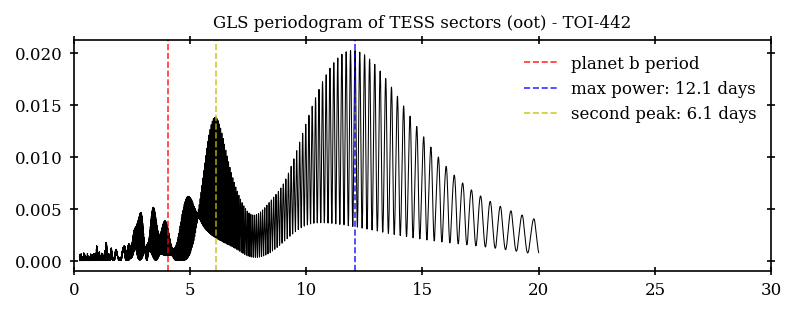

In [162]:
# first remove in-transit points from results 1
lslc = ls(lc.time.value[~in_transit], lc.flux[~in_transit], lc.flux_err[~in_transit])
lc_freq, lc_power = lslc.autopower(minimum_frequency=0.05, maximum_frequency=4, samples_per_peak=50)

# # plot the periodogram
fig, ax = plt.subplots(1, 1, figsize=(6,2), dpi=150)
ax.plot(1/lc_freq, lc_power, color='k', linewidth=0.5)
ax.set_xlim(0,30)
#ax.set_ylim(0, 0.01)
ax.axvline(period_tess.nominal_value, color='r', linestyle='--', linewidth=0.8, alpha=0.8, label='planet b period')
ax.axvline(1/lc_freq[np.argmax(lc_power)], color='b', linestyle='--', linewidth=0.8, alpha=0.8, 
           label='max power: '+str(np.round(1/lc_freq[np.argmax(lc_power)],2))+' days')
ax.axvline(6.1, color='y', linestyle='--', linewidth=0.8, alpha=0.8, 
           label='second peak: '+str(np.round(6.1,2))+' days')
ax.legend(frameon=False, markerscale=0)
ax.set_title(f'GLS periodogram of TESS sectors (oot) - {star_name}')
plt.savefig(f'./plots/toi442/tess_oot_gls_{star_name}.png', dpi=200, bbox_inches='tight', pad_inches=0.1)

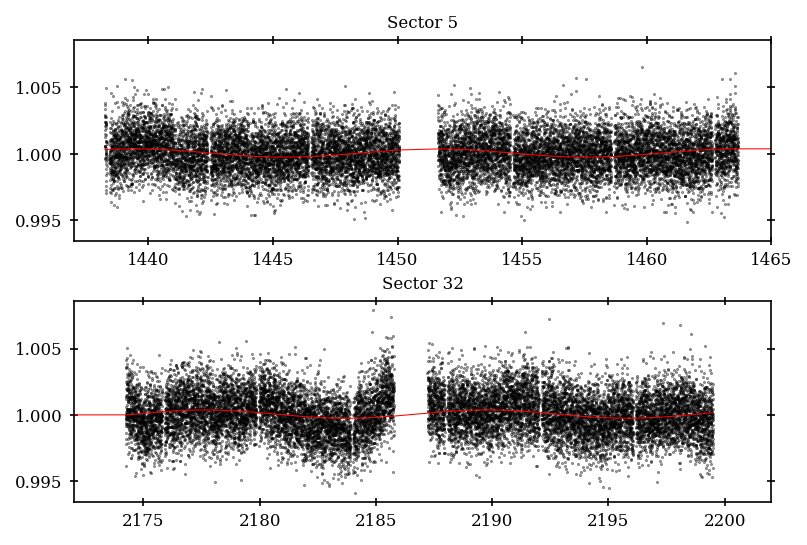

In [163]:
y_fit = lslc.model(lc.time.value[~in_transit], lc_freq[np.argmax(lc_power)])
fig, ax = plt.subplots(2, 1, figsize=(6,4), dpi=150)
fig.subplots_adjust(hspace=0.3)
ax[0].plot(lc.time.value[~in_transit], y_fit, color='r', linewidth=0.5)
ax[0].set_xlim(1437,1465)
ax[0].scatter(lc.time.value[~in_transit], lc.flux[~in_transit], color='k', s=0.2, alpha=0.5)
ax[0].set_title('Sector 5')

ax[1].plot(lc.time.value[~in_transit], y_fit, color='r', linewidth=0.5)
ax[1].set_xlim(2172,2202)
ax[1].scatter(lc.time.value[~in_transit], lc.flux[~in_transit], color='k', s=0.2, alpha=0.5)
ax[1].set_title('Sector 32')
plt.savefig(f'./plots/toi442/tess-modulation_{star_name}.png', dpi=200, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [164]:
# compare rms of residuals and rms of data
rms_data = np.std(lc.flux[~in_transit])
rms_res = np.std(lc.flux[~in_transit] - y_fit)
print(rms_data*1e3, rms_res*1e3)

1.5553070697933435 1.5393647417029754


## Modelo Global

### Model variables

In [336]:
def get_xy(time, version='short'):
    # parametros
    # ----------
    # time: '120', '300' (int)
    # devuelve
    # ----------
    # x, y, yerr, texp (en días y ppt)
    if version == 'all':
        if time == 120:
            t = time
            flux = flux
            flux_err = flux_err
            texp = texp
            id = sector_id
        elif time == 300:
            t = time_5min
            flux = flux_5min
            flux_err = flux_err_5min
            texp = texp_binned
            id = sector_id_5min
    elif version == 'short':
        if time == 120:
            t = time[intransit]
            flux = flux[intransit]
            flux_err = flux_err[intransit]
            texp = texp
            id = sector_id[intransit]
        elif time == 300:
            t = time_5min[intransit_5min]
            flux = flux_5min[intransit_5min]
            flux_err = flux_err_5min[intransit_5min]
            texp = texp_binned
            id = sector_id_5min[intransit_5min]

    x = np.ascontiguousarray(t - ref_time, dtype=np.float64)
    y = np.ascontiguousarray(1e3 * (flux - 1.0), dtype=np.float64) # Here we convert flux to ppt
    yerr = np.ascontiguousarray(1e3 * flux_err, dtype=np.float64) 
    return x, y, yerr, texp, id

In [337]:
# lc para modelo
x, y, yerr, texp, id = get_xy(300, 'short')

# rvs
# x_rv, y_rv, yerr_rv, rv_inst_id
x_rv = x_rv - ref_time

In [338]:
K_est = xo.estimate_semi_amplitude(results.period, x_rv, y_rv, yerr_rv, t0s=results.T0-ref_time)
print(K_est, "m/s")

[18.22645159] m/s


### Model version

In [339]:
# versiones
# 0: GP in LC, per instrument offset en RVs
# 1: GP in LC, per instrument offset + quadratic drift en RVs
# 2: GP in LC, noise GP in RVs
version_names = ['offset', 'drift', 'GP']
#version = 0
version = 1
#version = 2

### Model build

In [340]:
# version with GP in LC, offset in RV
phase_lc = np.linspace(-0.3, 0.3, 500)
t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1500)
# Compute a reference time that will be used to normalize the trends model
x_ref = 0.5 * (x_rv.min() + x_rv.max())

with pm.Model() as model:
    # Parameters for the stellar properties
    u_star = xo.QuadLimbDark("u_star")
    star = xo.LimbDarkLightCurve(u_star)

    # Stellar parameters from TESS
    mstar = pm.TruncatedNormal("mstar", mu=stmass_tess.n, sigma=stmass_tess.s, lower=0.0, upper=1.0)
    rstar = pm.TruncatedNormal("rstar", mu=strad_tess.n, sigma=strad_tess.s, lower=0.0, upper=1.0)

    # Orbital parameters for the planet
    t0 = pm.Normal("t0", mu=results.T0-ref_time, sigma=3*results.duration)
    logP = pm.Normal("logP", mu=np.log(results.period), sigma=results.period_uncertainty/results.period)
    P = pm.Deterministic("P", pt.exp(logP))
    K = pm.Uniform("K", lower=0, upper=3*y_rv.std())

    # Fit in terms of ror
    log_ror = pm.Normal("log_ror", mu=0.5*np.log((1-np.nanmean(results.transit_depths))), sigma=1)
    ror = pm.Deterministic("ror", pt.exp(log_ror))
    r_pl = pm.Deterministic("r_pl", ror * rstar)
    b = xo.ImpactParameter('b', ror)
 
    h, k = xo.unit_disk("h", "k", initval=np.array([0.01, 0.01]))
    ecc = pm.Deterministic("e", h**2 + k**2)
    omega = pm.Deterministic("w", pt.arctan2(k, h))

    # derived parameters
    m_pl = pm.Deterministic('m_pl', K*pt.sqrt(1-ecc**2)*(P*u.day.to(u.second)*(mstar*u.M_sun.to(u.kg))**2/(2*np.pi*constants.G))**(1/3)*u.kg.to(u.M_earth))
    density_pl = pm.Deterministic('density_pl', m_pl*u.M_earth.to(u.g)/(4/3*np.pi*(r_pl*u.R_sun.to(u.cm))**3))    
    a = pm.Deterministic('a', ((P*u.day.to(u.second))**2*constants.G*(mstar*u.M_sun.to(u.kg)+m_pl*u.M_earth.to(u.kg))/(4*np.pi**2))**(1/3)*u.m.to(u.au))
    teq = pm.Deterministic('teq', stteff_pub.n*(rstar*u.R_sun.to(u.au)/a)**(1/2)*(1/4)**(1/4))
   
    # Orbit model
    orbit = xo.orbits.KeplerianOrbit(
            r_star=rstar,
            m_star=mstar,
            period=P,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
            )
    
    if version == 0:
        lc_models = dict()
        lc_phase_models = dict()
        # Function to compute he light curve model
        def lc_model(mean, star, r_pl, texp, t):
            return pt.sum(1e3*star.get_light_curve(orbit=orbit, r=r_pl, t=t, texp=texp), axis=-1) + mean

        # divide the LC data in three sectors
        for i, name in enumerate(sector_id_names):
            with pm.Model(name=name, model=model):
                # a mean for each sector
                lc_mean = pm.Normal("lc_mean", mu=0.0, sigma=1.0)

                # LC jitter & GP parameters
                log_sigma_lc = pm.Normal("log_sigma_lc", mu=np.log(np.std(y[id == i])), sigma=10)
                log_rho_gp = pm.Normal("log_rho_gp", mu=0, sigma=10)
                log_sigma_gp = pm.Normal("log_sigma_gp", mu=np.log(np.std(y[id == i])), sigma=10)

            # compute the model light curve
            lc_models[name] = lc_model(lc_mean, star, r_pl, texp, x[id == i])
            lc_phase_models[name] = lc_model(lc_mean, star, r_pl, texp, t0 + phase_lc)

            # Compute and save the light curve models
            pm.Deterministic(f"{name}_lc", lc_models[name])
            pm.Deterministic(f"{name}_lc_phase", lc_phase_models[name])

            kernel = terms.SHOTerm(
                sigma=pt.exp(log_sigma_gp),
                rho=pt.exp(log_rho_gp),
                Q=1 / np.sqrt(2))
        
            gp_lc = GaussianProcess(kernel, t=x[id == i], mean=lc_models[name], yerr=pt.exp(log_sigma_lc))
            gp_lc.marginal(f"{name}_obs_lc", observed=y[id == i])
            pm.Deterministic(f"{name}_gp_lc_pred", gp_lc.predict(y[id == i], include_mean=False))
    
        # Function for computing the full RV model
        def get_rv_model(x, name=""):
            vrad = orbit.get_radial_velocity(x, K=K)
            pm.Deterministic("vrad" + name, vrad)
            return pm.Deterministic("rv_model" + name, vrad)

        # Loop over the instruments
        parameters = dict()
        rv_models = dict()

        # Per instrument offset and jitter
        means = pm.Normal("means", mu=np.array([np.median(y_rv[rv_inst_id == i]) for i in range(len(rv_inst_names))]), sigma=5, shape=len(rv_inst_names))
        log_sigmas_rv = pm.Normal("log_sigmas_rv", mu=np.log(np.array([(np.median(yerr_rv[rv_inst_id == i])) for i in range(len(rv_inst_names))])), sigma=1)

        mean = pt.zeros(len(x_rv))
        sigma = pt.zeros(len(x_rv))
        for i in range(len(rv_inst_names)):
            mean += means[i] * (rv_inst_id == i)
            sigma += (yerr_rv**2 + pt.exp(2 * log_sigmas_rv[i]) * (rv_inst_id == i))

        pm.Deterministic("mean", mean)
        pm.Deterministic("sigma", sigma)

        # rv model
        rv_mod = get_rv_model(x_rv) + mean
        get_rv_model(t_rv, "_pred")

        # the likelihood for the rvs
        err = pt.sqrt(sigma)
        pm.Normal("obs", mu=rv_mod, sigma=err, observed=y_rv)

    elif version == 1:
        
        lc_models = dict()
        lc_phase_models = dict()
        # Function to compute he light curve model
        def lc_model(mean, star, r_pl, texp, t):
            return pt.sum(1e3*star.get_light_curve(orbit=orbit, r=r_pl, t=t, texp=texp), axis=-1) + mean

        # divide the LC data in three sectors
        for i, name in enumerate(sector_id_names):
            with pm.Model(name=name, model=model):
                # a mean for each sector
                lc_mean = pm.Normal("lc_mean", mu=0.0, sigma=1.0)

                # LC jitter & GP parameters
                log_sigma_lc = pm.Normal("log_sigma_lc", mu=np.log(np.std(y[id == i])), sigma=10)
                log_rho_gp = pm.Normal("log_rho_gp", mu=0, sigma=10)
                log_sigma_gp = pm.Normal("log_sigma_gp", mu=np.log(np.std(y[id == i])), sigma=10)

            # compute the model light curve
            lc_models[name] = lc_model(lc_mean, star, r_pl, texp, x[id == i])
            lc_phase_models[name] = lc_model(lc_mean, star, r_pl, texp, t0 + phase_lc)

            # Compute and save the light curve models
            pm.Deterministic(f"{name}_lc", lc_models[name])
            pm.Deterministic(f"{name}_lc_phase", lc_phase_models[name])

            kernel = terms.SHOTerm(
                sigma=pt.exp(log_sigma_gp),
                rho=pt.exp(log_rho_gp),
                Q=1 / np.sqrt(2))
            
            gp_lc = GaussianProcess(kernel, t=x[id == i], mean=lc_models[name], yerr=pt.exp(log_sigma_lc))
            gp_lc.marginal(f"{name}_obs_lc", observed=y[id == i])
            pm.Deterministic(f"{name}_gp_lc_pred", gp_lc.predict(y[id == i], include_mean=False))
        
        # RV quadratic trend, remove the constant term because we're using a per instrument mean
        trend = pm.Normal("trend", mu=0, sigma=np.array([0.01, 0.1]), shape=2)
        # Function for computing the full RV model
        def get_rv_model(x, name=""):
            vrad = orbit.get_radial_velocity(x, K=K)
            pm.Deterministic("vrad" + name, vrad)

            # Define the background model
            # Use only the first two columns (we removed the constant term)
            A = np.vander(x - x_ref, 3)[:,0:2]
            bkg = pm.Deterministic("bkg" + name, pt.dot(A, trend))

            return pm.Deterministic("rv_model" + name, vrad + bkg)
        
        # Loop over the instruments
        parameters = dict()
        rv_models = dict()

        # Per instrument offset and jitter
        means = pm.Normal("means", mu=np.array([np.median(y_rv[rv_inst_id == i]) for i in range(len(rv_inst_names))]), sigma=5, shape=len(rv_inst_names))
        log_sigmas_rv = pm.Normal("log_sigmas_rv", mu=np.log(np.array([(np.median(yerr_rv[rv_inst_id == i])) for i in range(len(rv_inst_names))])), sigma=1)

        mean = pt.zeros(len(x_rv))
        sigma = pt.zeros(len(x_rv))
        for i in range(len(rv_inst_names)):
            mean += means[i] * (rv_inst_id == i)
            sigma += (yerr_rv**2 + pt.exp(2 * log_sigmas_rv[i]) * (rv_inst_id == i))

        pm.Deterministic("mean", mean)
        pm.Deterministic("sigma", sigma)

        # rv model
        rv_mod = get_rv_model(x_rv) + mean
        get_rv_model(t_rv, "_pred")

        # the likelihood for the rvs
        err = pt.sqrt(sigma)
        pm.Normal("obs", mu=rv_mod, sigma=err, observed=y_rv)

    elif version == 2:
        print('version 2')
        # # LC jitter & GP parameters
        # log_sigma_lc = pm.Normal("log_sigma_lc", mu=np.log(np.std(y)), sigma=10)
        # log_rho_gp = pm.Normal("log_rho_gp", mu=0, sigma=10)
        # log_sigma_gp = pm.Normal("log_sigma_gp", mu=np.log(np.std(y)), sigma=10)

        # # RV noise & GP parameters
        # log_sigma_gp_rv = pm.Normal("log_sigma_gp_rv", mu=np.log(np.std(y_rv)), sigma=10)
        # log_rho_gp_rv = pm.Normal("log_rho_gp_rv", mu=np.log(50), sigma=50)
        # #log_sigma_rv = pm.Normal("log_sigma_rv", mu=np.log(np.std(y_rv)), sigma=10)
        
        # # Compute the model light curve
        # light_curves = (star.get_light_curve(orbit=orbit, r=r_pl, t=x, texp=texp_short)* 1e3)
        # light_curve = pm.math.sum(light_curves, axis=-1) + lc_mean

        # # GP model for the light curve
        # kernel = terms.SHOTerm(
        #         sigma=pt.exp(log_sigma_gp),
        #         rho=pt.exp(log_rho_gp),
        #         Q=1 / np.sqrt(2),)
    
        # gp_lc = GaussianProcess(kernel, t=x, mean=light_curve, yerr=pt.exp(log_sigma_lc))
        # gp_lc.marginal("obs_lc", observed=y)

        # # Compute and save the phased light curve models
        # pm.Deterministic("lc_pred", 1e3*star.get_light_curve(orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp_short)[..., 0],)
        # pm.Deterministic("gp_lc_pred", gp_lc.predict(y, include_mean=False))

        # # RVs
        # # Per instrument parameters
        # sigmas = pm.HalfNormal("sigmas", sigma=10, shape=len(rv_inst_names))

        # # Compute the RV offset and jitter for each data point depending on its instrument
        # diag = pt.zeros(len(x_rv))
        # for i in range(len(rv_inst_names)):
        #     diag += (yerr_rv**2 + sigmas[i] ** 2) * (rv_inst_id == i)
        # pm.Deterministic("rv_mean", rv_mean)
        # pm.Deterministic("diag", diag)

        # def get_rv_model(x, name=""):
        #     vrad = orbit.get_radial_velocity(x, K=K)
        #     pm.Deterministic("vrad" + name, vrad)
        #     return pm.Deterministic("rv_model" + name, vrad)
    
        # rv_model = get_rv_model(x_rv)
        # get_rv_model(t_rv, "_pred")

        # kernelrv = terms.SHOTerm(
        #     sigma=pt.exp(log_sigma_gp_rv), 
        #     rho=pt.exp(log_rho_gp_rv), 
        #     Q=1.0 / 3)
        
        # gp_rv = GaussianProcess(kernelrv, t=x_rv, mean=rv_model, diag=diag)
        # gp_rv.marginal("obs_rv", observed=y_rv)
        # pm.Deterministic("gp_rv_pred", gp_rv.predict(y_rv, include_mean=True))

    else:
        raise ValueError('Version not found')
    
    # Find MAP
    map_params = pm.find_MAP()
    map_soln = pmx.optimize(start=map_params)

Output()

Output()

#### LC map plot

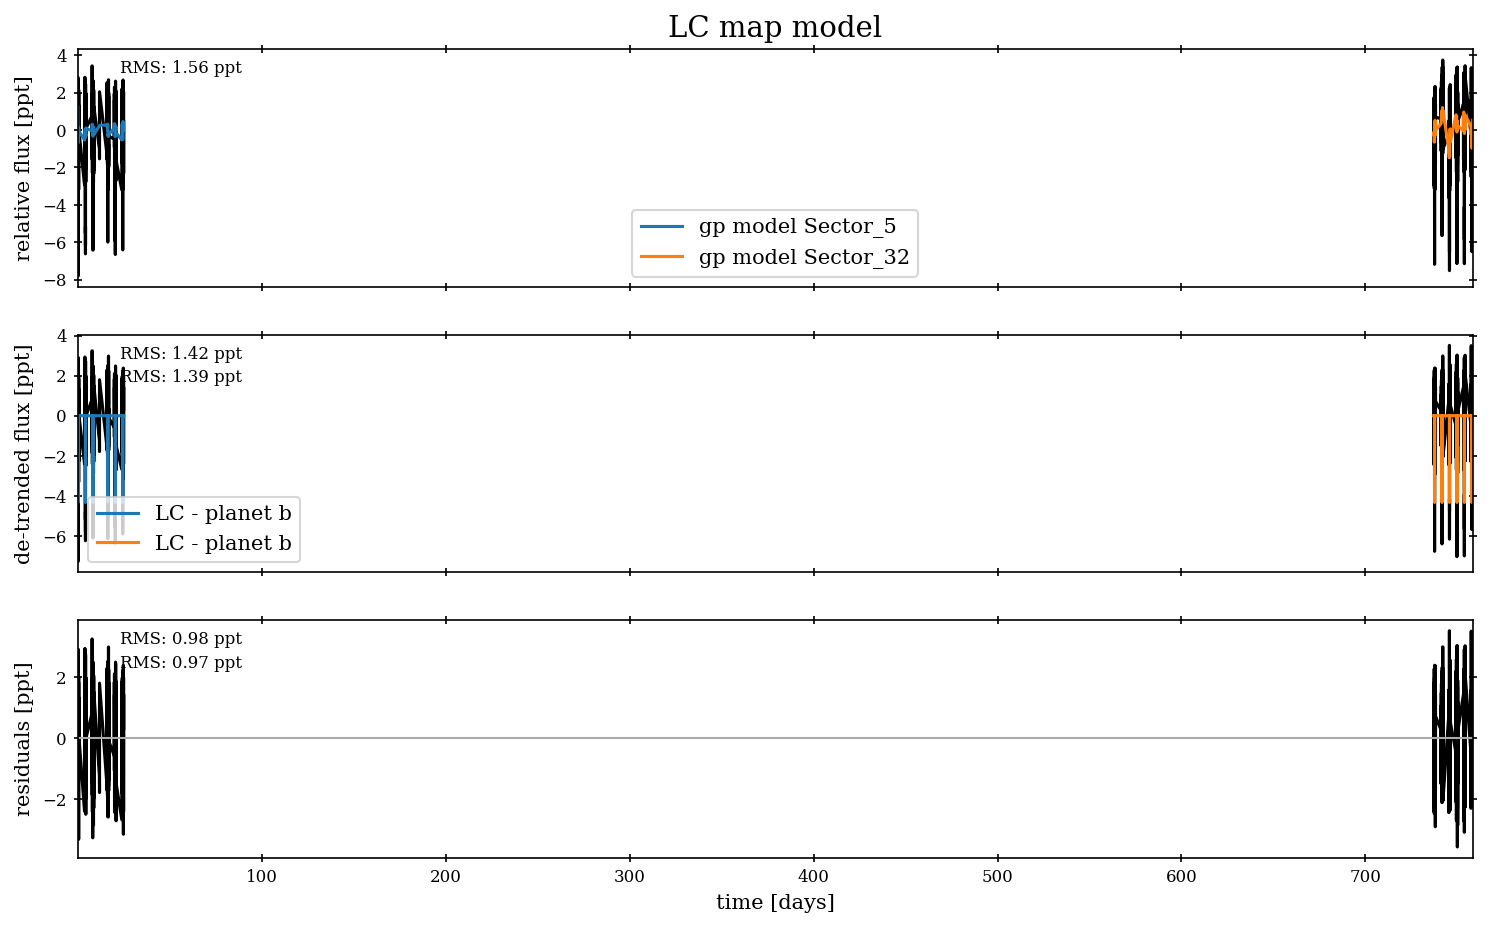

In [341]:
fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)

ax = axes[0]
for i, name in enumerate(sector_id_names):
    lc_mod = map_soln[f"{name}_lc"] # lc + mean
    gp = map_soln[f"{name}_gp_lc_pred"] # gp model (on top of lc + mean)
    # first plot the lc model with GP
    ax.plot(x[id == i], y[id == i], "k")
    ax.plot(x[id == i], gp, label="gp model {}".format(name))
ax.text(x=0.03, y=0.9, s=f'RMS: {np.std(y):.2f} ppt', transform=ax.transAxes)
ax.legend(fontsize=10)
ax.set_ylabel("relative flux [ppt]")
ax.set_title('LC map model', fontsize=14)

# then detrend data for gp model and plot the lc model
ax = axes[1]
for i, name in enumerate(sector_id_names):
    lc_mod = map_soln[f"{name}_lc"] # lc + mean
    gp = map_soln[f"{name}_gp_lc_pred"]
    ax.plot(x[id == i], y[id == i] - gp, "k")
    ax.plot(x[id == i], lc_mod, label="LC - planet {0}".format(b))
    ax.text(x=0.03, y=0.9-i/10, s=f'RMS: {np.std(y[id == i] - gp):.2f} ppt', transform=ax.transAxes)
ax.legend(fontsize=10, loc=3)
ax.set_ylabel("de-trended flux [ppt]")

# residuals of gp + lc model
ax = axes[2]
for i, name in enumerate(sector_id_names):
    lc_mod = map_soln[f"{name}_lc"] # lc + mean
    gp = map_soln[f"{name}_gp_lc_pred"]
    ax.plot(x[id == i], y[id == i] - gp - lc_mod, "k")
    ax.text(x=0.03, y=0.9-i/10, s=f'RMS: {np.std(y[id == i] - gp - lc_mod):.2f} ppt', transform=ax.transAxes)
ax.axhline(0, color="#aaaaaa", lw=1)
ax.set_ylabel("residuals [ppt]")
ax.set_xlim(x.min(), x.max())
ax.set_xlabel("time [days]")
#plt.xlim(345, 360)

plt.savefig(f'./plots/toi442/map_lc_{version_names[version]}.png', dpi=200, bbox_inches='tight', pad_inches=0.1)
plt.show()

#### RV map plot

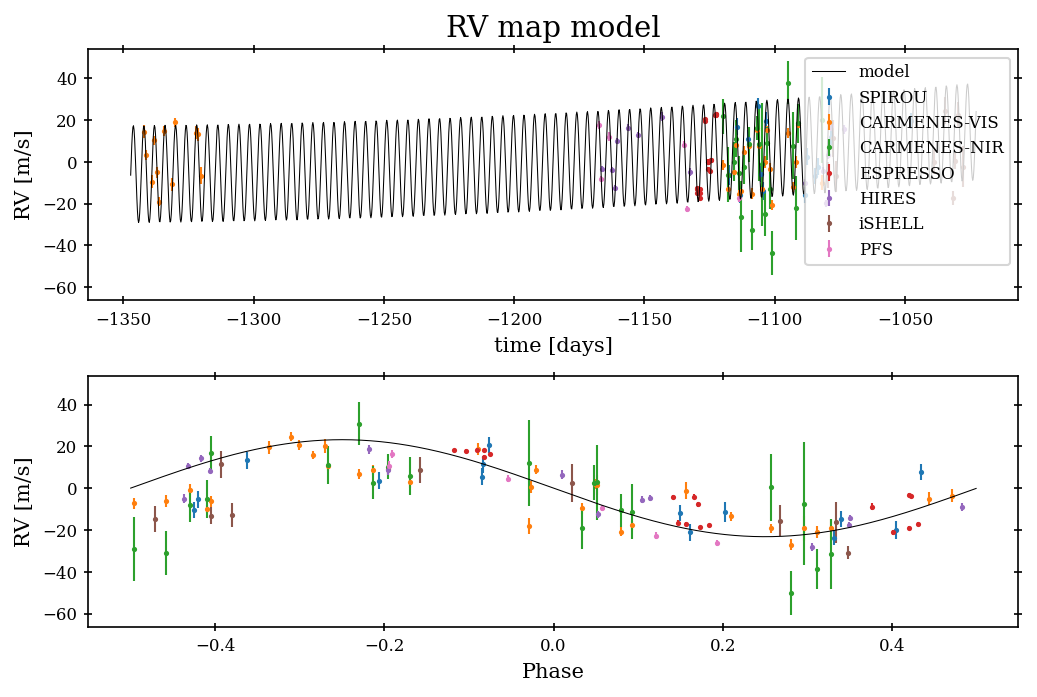

In [342]:
fig, ax = plt.subplots(2, 1, figsize=(8, 5), sharey=True)
fig.subplots_adjust(hspace=0.3)

for i, name in enumerate(rv_inst_names):
    m = rv_inst_id == i
    ax[0].errorbar(x_rv[m], y_rv[m] - map_soln["mean"][m], yerr=yerr_rv[m], fmt=".", 
                   elinewidth=1, markersize=3, label=name, zorder=-1000)
ax[0].plot(t_rv, map_soln["rv_model_pred"], lw=0.5, color="k", label="model")
ax[0].set_ylabel("RV [m/s]")
ax[0].set_xlabel("time [days]")
ax[0].legend(fontsize=8, loc='upper right', frameon=True)
ax[0].set_title('RV map model', fontsize=14)

folded = (x_rv - map_soln["t0"] + 0.5 * map_soln["P"]) % map_soln["P"] - 0.5 * map_soln["P"]
inds = np.argsort(folded)
for i, name in enumerate(rv_inst_names):
    m = rv_inst_id == i
    xfold = (x_rv[m] - map_soln["t0"] + 0.5 * map_soln["P"]) % map_soln["P"] - 0.5 * map_soln["P"]
    inds = np.argsort(xfold)
    if version == 0:
        ax[1].errorbar(xfold[inds]/map_soln["P"], y_rv[m][inds] - map_soln["mean"][m], yerr=yerr_rv[m][inds], fmt=".",
                    elinewidth=1, markersize=3, label=name, zorder=-1000)
    elif version == 1:
        ax[1].errorbar(xfold[inds]/map_soln["P"], y_rv[m][inds] - map_soln["mean"][m] - map_soln["bkg"][m][inds], yerr=yerr_rv[m][inds], fmt=".",
                    elinewidth=1, markersize=3, label=name, zorder=-1000)
folded_t = (t_rv - map_soln["t0"] + 0.5 * map_soln["P"]) % map_soln["P"] - 0.5 * map_soln["P"]
inds2 = np.argsort(folded_t)
if version == 0:
    ax[1].plot(folded_t[inds2]/map_soln["P"], map_soln["rv_model_pred"][inds2], "k", lw=0.5)
elif version == 1:
    ax[1].plot(folded_t[inds2]/map_soln["P"], map_soln["rv_model_pred"][inds2] - map_soln['bkg_pred'][inds2], "k", lw=0.5)
ax[1].set_ylabel("RV [m/s]")
ax[1].set_xlabel("Phase")
plt.savefig(f'./plots/toi442/map_rv_{version_names[version]}.png', dpi=200, bbox_inches='tight', pad_inches=0.1)

### Posterior Sampling

In [277]:
# with model:
#     trace = pm.sample(
#         draws=1000,
#         tune=1000,
#         initvals=map_soln,
#         chains=2,
#         target_accept=0.95,
#         init="adapt_full",
#     )

In [323]:
# # trace to save
# az.to_netcdf(trace, f'trace.global{star_name}_v{version}_{version_names[version]}.save')

# save to trace
trace = az.from_netcdf(f'trace.global{star_name}_v{version}_{version_names[version]}.save')

In [324]:
summary = az.summary(trace, stat_funcs={'median': np.median, 'std':np.std}, hdi_prob=0.997, round_to=6,
                     var_names=[
                         "t0",
                         "P",
                         "K",
                         "b",
                         "m_pl",
                         "density_pl",
                         "a",
                         "teq",
                         "e",
                         "ror",
                         "r_pl",
                         "rstar",
                         "mstar",
                         "u_star",
                         "w",
                     ])
summary

,mean,sd,hdi_0.15%,hdi_99.85%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,std
t0,0.131486,0.000400,0.130492,0.132737,0.000009,0.000006,1942.901483,1363.991727,1.001682,0.131483,0.000400
P,4.052032,0.000003,4.052023,4.052041,0.000000,0.000000,2430.569658,1481.951391,1.001648,4.052032,0.000003
K,18.544593,1.037448,15.590034,21.601610,0.021467,0.015181,2327.545343,1252.479290,1.002872,18.542155,1.037188
b,0.750871,0.036783,0.627171,0.836963,0.001291,0.000913,904.548365,672.016144,1.001037,0.754990,0.036774
m_pl,32.534506,1.993076,26.305365,37.749769,0.042318,0.029928,2223.519047,887.919357,1.000517,32.563316,1.992577
density_pl,1.512787,0.211300,0.976783,2.173923,0.005285,0.003780,1619.527897,1394.443269,1.002492,1.496445,0.211247
a,0.041776,0.000482,0.040399,0.043096,0.000010,0.000007,2237.764654,1286.880652,0.999725,0.041781,0.000482
teq,728.058449,10.664356,696.707635,758.486391,0.213615,0.151067,2494.351652,1521.796289,1.000808,727.872458,10.661689
e,0.061766,0.032726,0.000016,0.165971,0.001069,0.000773,964.689589,1099.330685,0.999959,0.059643,0.032717
ror,0.073945,0.001925,0.068823,0.079725,0.000064,0.000046,876.514135,1122.735149,0.999739,0.073824,0.001925


### Resulting parameters

In [325]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

In [326]:
import pickle
import math
from uncertainties import ufloat
from uncertainties.umath import *
from asymmetric_uncertainty import a_u

params = {}
with open(f'./results/toi442/{star_name}_v{version}_{version_names[version]}.txt', 'w') as f:
    for var in flat_samps.data_vars:
        if flat_samps[var].ndim > 1 and flat_samps[var].shape[0] > 10:
            continue
        else:
            if flat_samps[var].ndim > 1:
                for n in range(flat_samps[var].shape[0]):
                    parameter = a_u(flat_samps[var].median(dim='sample').values[n],
                                flat_samps[var].quantile(q=0.84, dim='sample').values[n]-flat_samps[var].median(dim='sample').values[n],
                                flat_samps[var].median(dim='sample').values[n]-flat_samps[var].quantile(q=0.16, dim='sample').values[n])
                    print(var+f'_{n}', " = {r:.6f}".format(r=parameter))
                    params[var+f'_{n}'] = parameter
                    f.write(var+f'_{n} = {parameter:.6f}\n')
            else:
                if var == 'r_pl':
                    parameter = a_u(flat_samps[var].median().item()*u.R_sun.to(u.R_earth),
                                flat_samps[var].quantile(q=0.84).item()*u.R_sun.to(u.R_earth)-flat_samps[var].median().item()*u.R_sun.to(u.R_earth),
                                flat_samps[var].median().item()*u.R_sun.to(u.R_earth)-flat_samps[var].quantile(q=0.16).item()*u.R_sun.to(u.R_earth))
                else:
                    parameter = a_u(flat_samps[var].median().item(),
                                    flat_samps[var].quantile(q=0.84).item()-flat_samps[var].median().item(),
                                    flat_samps[var].median().item()-flat_samps[var].quantile(q=0.16).item())
                print(var, " = {r:.6f}".format(r=parameter))
                params[var] = parameter
                f.write(f'{var} = {parameter:.6f}\n')
    print('----------------')
    for i, inst in enumerate(rv_inst_names):
        jitter = np.e**params['log_sigmas_rv_'+str(i)]
        params[f'{inst}_jitter'] = jitter
        print(f'{inst}_jitter = {jitter:.3f}')
        f.write(f'{inst}_jitter = {jitter:.3f}\n')
    print('----------------')
    # GP timescale on LC, derived from log_rho_gp
    for sector in sector_id_names:
        timescale = np.exp(params[f'{sector}::log_rho_gp'])/(np.sqrt(2)*np.pi)
        params[f'{sector}_timescale'] = timescale
        print(f'{sector}_timescale = {timescale:.3f}')
        f.write(f'{sector}_timescale = {timescale:.3f}\n')
    # save to pickle
with open(f'./results/toi442/{star_name}_v{version}_{version_names[version]}.pkl', 'wb') as f1:
    pickle.dump(params, f1)
f.close()
f1.close()                            

K  = 18.542155 (+1.022352, -1.042645)
P  = 4.052032 (+0.000003, -0.000003)
Sector_32::lc_mean  = 0.130397 (+0.172060, -0.175123)
Sector_32::log_rho_gp  = 0.266132 (+0.740832, -0.620800)
Sector_32::log_sigma_gp  = -0.451784 (+0.200607, -0.172595)
Sector_32::log_sigma_lc  = -0.020804 (+0.019932, -0.020369)
Sector_5::lc_mean  = 0.025593 (+0.032758, -0.032319)
Sector_5::log_rho_gp  = -0.426667 (+10.656062, -7.578282)
Sector_5::log_sigma_gp  = -4.832312 (+3.158957, -7.353189)
Sector_5::log_sigma_lc  = -0.018115 (+0.018765, -0.019083)
__b_impact_parameter  = 0.702801 (+0.029436, -0.034853)
__k_unit_disk  = 0.123580 (+0.126435, -0.164523)
__u_star_q1  = 0.480192 (+0.272257, -0.179887)
__u_star_q2  = 0.327489 (+0.373675, -0.225743)
a  = 0.041781 (+0.000498, -0.000491)
b  = 0.754990 (+0.032532, -0.038869)
density_pl  = 1.496445 (+0.224466, -0.192015)
e  = 0.059643 (+0.034563, -0.030539)
h  = -0.166427 (+0.098101, -0.069291)
k  = 0.121518 (+0.126007, -0.161520)
logP  = 1.399218 (+0.000001, -0.00

In [327]:
# improve period uncertainty?
# dreizler et al: 4.052037 +/- 0.000004
params['P']

In [194]:
# precision in Radius in Dreizler paper is 6.3 %
# here is 4.4 %
params['r_pl']

### Cornerplot

In [328]:
CORNER_KWARGS = dict(
    smooth=0.5,
    plot_density=True,
    plot_datapoints=True,
    fill_contours=False,
    #levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    levels=(0.16,0.5,0.84),
    max_n_ticks=3
)

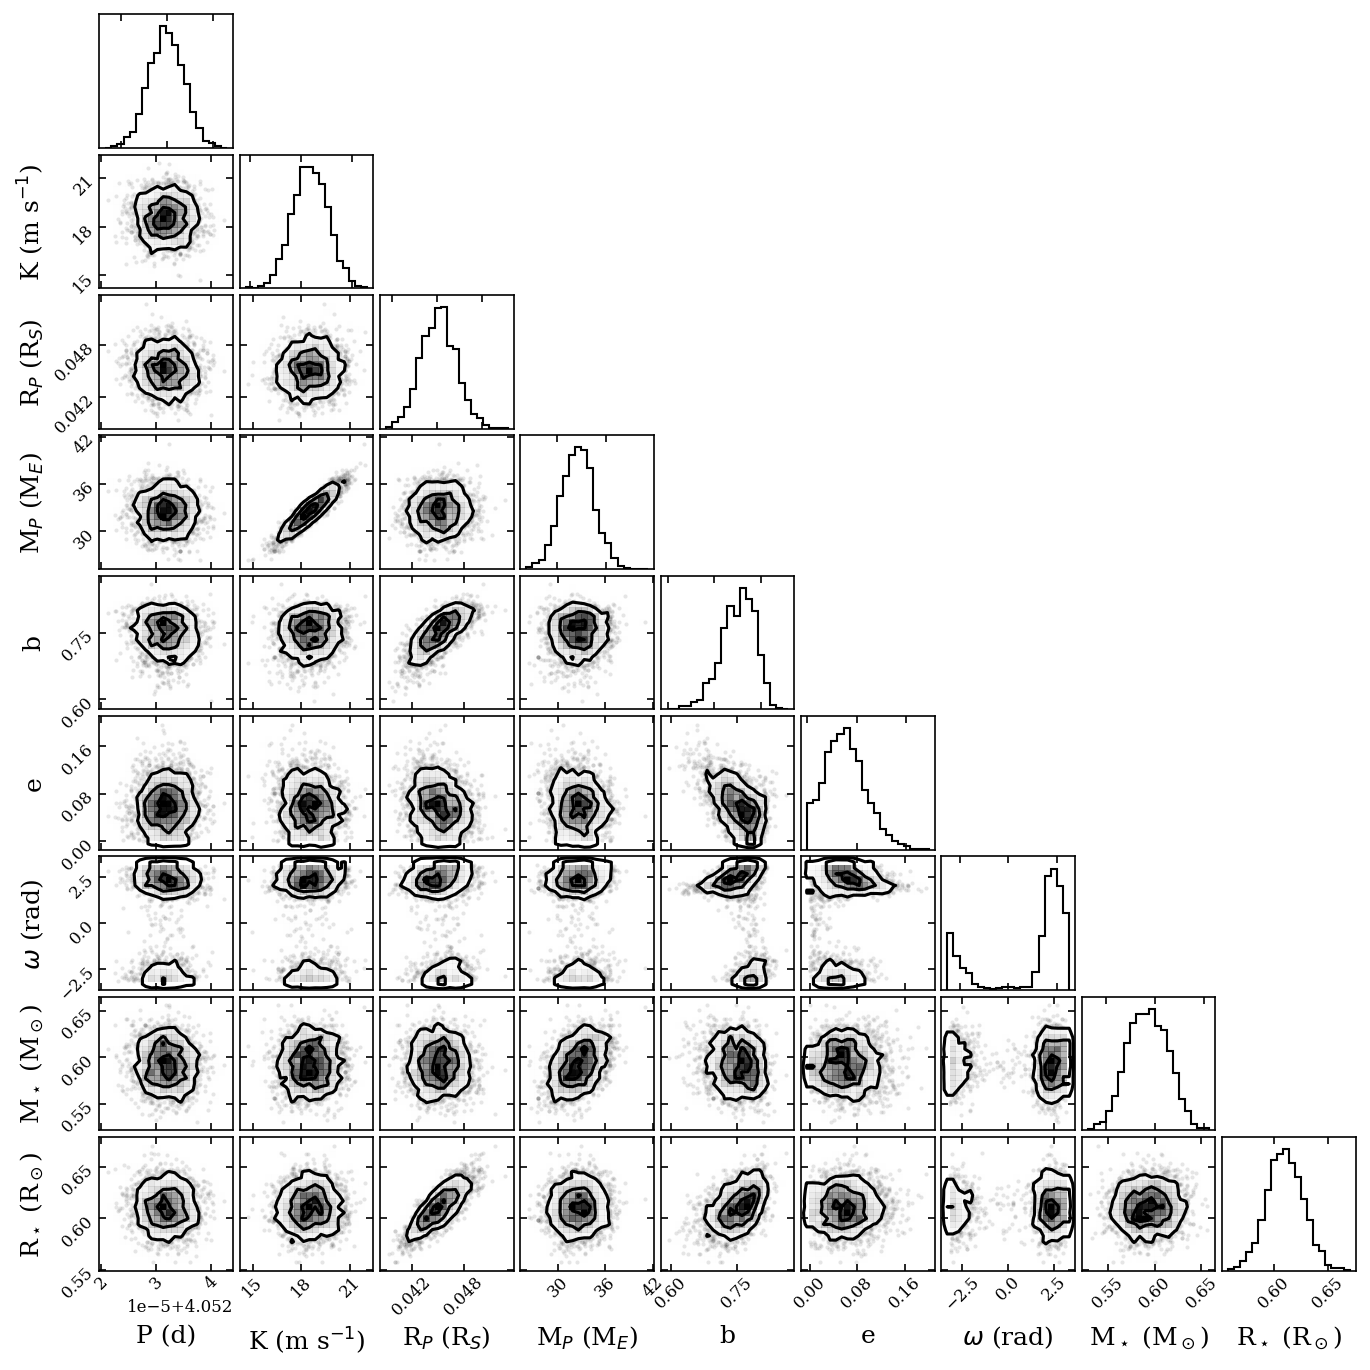

In [329]:
from cProfile import label
import corner
from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter()

fig, ax = plt.subplots(9, 9, figsize=(9, 9))

figure = corner.corner(trace, var_names=['P', 'K', 'r_pl', 'm_pl', 'b', 'e', 'w', 'mstar', 'rstar'],
                        labels=["P (d)", "K (m s$^{-1}$)", "R$_P$ (R$_S$)", "M$_P$ (M$_E$)", "b", "e", "$\omega~$(rad)","M$_\star$ (M$_\odot$)","R$_\star$ (R$_\odot$)"], label_kwargs={'fontsize':12},
                        show_titles=False, title_kwargs={'fontsize':12, 'pad':9.0}, titles=['P', 'K', 'R\_P','M\_P','b','e','$\omega$','M\_$\star$','R\_$\star$'], divergences=False, plot_contours=True,
                        labelpad=0.1, color='k', fig=fig, **CORNER_KWARGS)
for i,ax in enumerate(figure.get_axes()):
    ax.tick_params(axis='both', pad=1, direction='in', labelbottom=True, labelleft=True, left=True, bottom=True)
    #ax.ticklabel_format(axis='both', style='plain', scilimits=None, useOffset=None, useLocale=None, useMathText=None)
    # if i == 71 or i == 72 or i == 73:
    #     ax.xaxis.set_major_formatter(formatter)

plt.savefig(f'./plots/toi442/corner_{star_name}_v{version}_{version_names[version]}.png', dpi=100, bbox_inches='tight', facecolor='w')
plt.show()

### RV fit plots

In [330]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

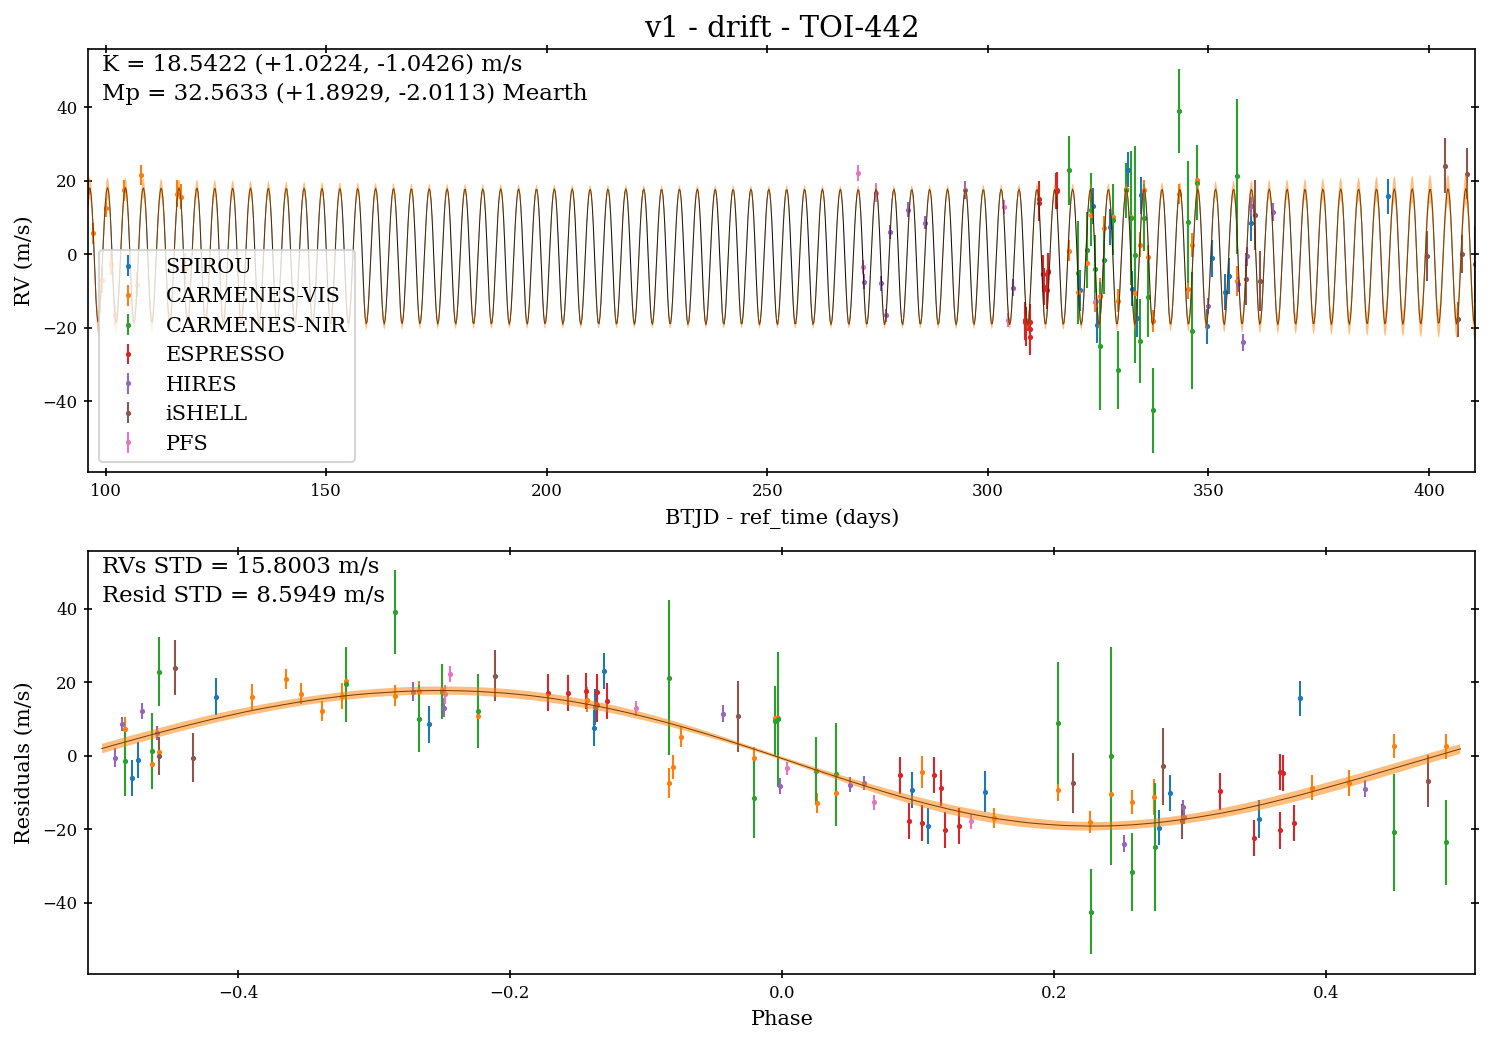

In [331]:
fig, ax = plt.subplots(2, 1, figsize=(10, 7), sharey=True)
fig.subplots_adjust(hspace=0.3)
period = np.median(flat_samps["P"])
t0_ = np.median(flat_samps["t0"])
rv_model = np.median(flat_samps['rv_model'].values, axis=-1)
rv_model_pred = np.percentile(flat_samps["rv_model_pred"].values, [16,50,84], axis=-1)
vrad_ = np.percentile(flat_samps["vrad"].values, [16,50,84], axis=-1)
vrad_pred_ = np.percentile(flat_samps["vrad_pred"].values, [16,50,84], axis=-1)

mean_ = flat_samps['mean'].median(axis=-1)
means = dict()
jitters = dict()
residuals = np.zeros(len(y_rv))
background = np.zeros(len(y_rv))
for i, name in enumerate(rv_inst_names):
    m = rv_inst_id == i
    means[name] = a_u(np.median(flat_samps["mean"].values, axis=-1)[m].mean(), 
                     np.quantile(flat_samps["mean"].values, q=0.84, axis=-1)[m].mean(),
                     np.quantile(flat_samps["mean"].values, q=0.16, axis=-1)[m].mean())   
    if version == 0: 
        background[m] = background[m] + mean_[m]
    elif version == 1:
        background[m] = background[m] + np.median(flat_samps['bkg'].values, axis=-1)[m] + mean_[m]
    residuals[m] = residuals[m] + (y_rv[m] - vrad_[1][m] - background[m])

ax[0].plot(t_rv, rv_model_pred[1], "k", lw=0.5)
art = ax[0].fill_between(t_rv, rv_model_pred[0], rv_model_pred[2], color="#FF7F00", alpha=0.5, zorder=2) 
art.set_edgecolor("none")
for i, name in enumerate(rv_inst_names):
    m = rv_inst_id == i
    ax[0].errorbar(x_rv[m], y_rv[m] - mean_[m], yerr=np.sqrt(yerr_rv[m]**2 + params[f'{name}_jitter']**2), fmt=".", 
                   elinewidth=1, markersize=3, label=name, zorder=-1000)
ax[0].legend(fontsize=10)
ax[0].set_xlim(x_rv.min(), x_rv.max())
ax[0].set_xlabel("BTJD - ref_time (days)")
ax[0].set_ylabel("RV (m/s)")
ax[0].set_title(f"v{version} - {version_names[version]} - {star_name}", fontsize=14)

for i, name in enumerate(rv_inst_names):
    m = rv_inst_id == i
    fold = (x_rv[m] - t0_ + 0.5 * period) % period - 0.5 * period
    inds = np.argsort(fold)
    ax[1].errorbar(fold[inds]/period, y_rv[m][inds] - background[m][inds], yerr=np.sqrt(yerr_rv[m][inds]**2 + params[f'{name}_jitter']**2), fmt=".", 
                   elinewidth=1, markersize=3, label=name, zorder=-1000)

fold2 = (t_rv - t0_ + 0.5 * period) % period - 0.5 * period
inds2 = np.argsort(fold2)
ax[1].plot(fold2[inds2]/period, vrad_pred_[1][inds2], "k", lw=0.5)
art = ax[1].fill_between(fold2[inds2]/period, vrad_pred_[0][inds2], vrad_pred_[2][inds2], color="#FF7F00", alpha=0.5, zorder=2) 
art.set_edgecolor("none")
ax[1].set_xlim(-0.51, 0.51)
ax[1].set_xlabel("Phase")
ax[1].set_ylabel("Residuals (m/s)")
ax[0].text(.01, .99, 'K = {k:.4f} m/s'.format(k=params['K']), fontsize=11, ha='left', va='top', transform=ax[0].transAxes)
ax[0].text(.01, .92, 'Mp = {k:.4f} Mearth'.format(k=params['m_pl']), fontsize=11, ha='left', va='top', transform=ax[0].transAxes)
ax[1].text(.01, .99, 'RVs STD = {k:.4f} m/s'.format(k=np.std(y_rv)), fontsize=11, ha='left', va='top', transform=ax[1].transAxes)
ax[1].text(.01, .92, 'Resid STD = {k:.4f} m/s'.format(k=np.std(residuals)), fontsize=11, ha='left', va='top', transform=ax[1].transAxes)
plt.tight_layout()
plt.savefig(f'./plots/toi442/rv_fit_{star_name}_v{version}_{version_names[version]}.png', dpi=300, facecolor='w', bbox_inches='tight')
plt.show()

Plot with residuals for paper

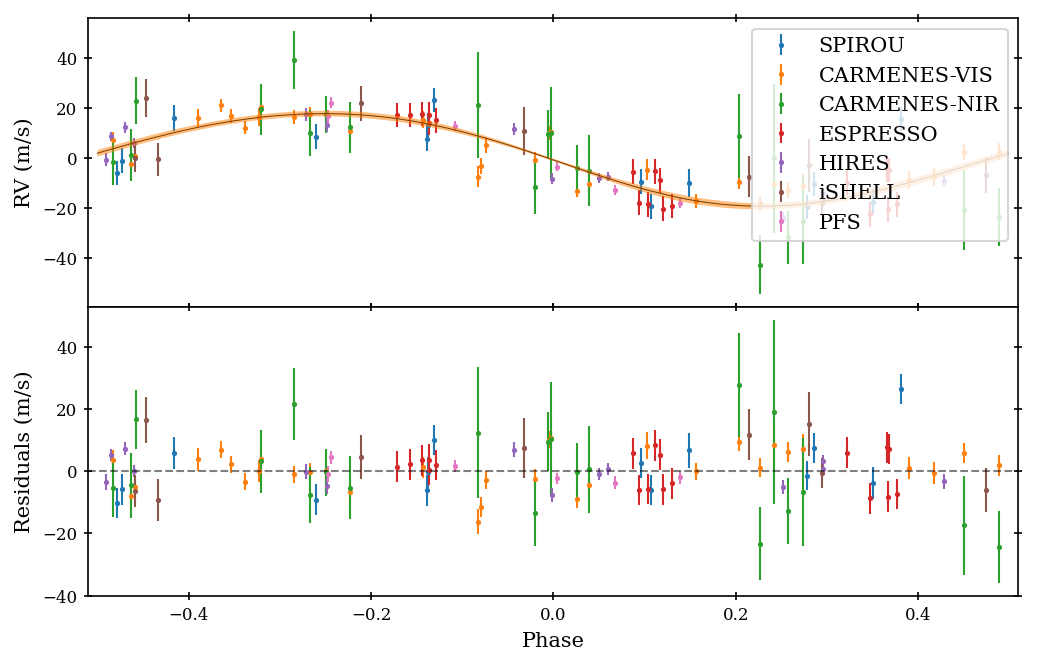

In [332]:
fig, ax = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
fig.subplots_adjust(hspace=0.0)

for i, name in enumerate(rv_inst_names):
    m = rv_inst_id == i
    fold = (x_rv[m] - t0_ + 0.5 * period) % period - 0.5 * period
    inds = np.argsort(fold)
    ax[0].errorbar(fold[inds]/period, y_rv[m][inds] - background[m][inds], yerr=np.sqrt(yerr_rv[m][inds]**2 + params[f'{name}_jitter']**2), fmt=".", 
                   elinewidth=1, markersize=3, label=name, zorder=-1000)

fold2 = (t_rv - t0_ + 0.5 * period) % period - 0.5 * period
inds2 = np.argsort(fold2)
ax[0].plot(fold2[inds2]/period, vrad_pred_[1][inds2], "k", lw=0.5)
art = ax[0].fill_between(fold2[inds2]/period, vrad_pred_[0][inds2], vrad_pred_[2][inds2], color="#FF7F00", alpha=0.5, zorder=2) 
art.set_edgecolor("none")
ax[0].legend(fontsize=10)
ax[0].set_xlim(-0.51, 0.51)

ax[0].set_ylabel("RV (m/s)")

# plot the residuals in the second panel
for i, name in enumerate(rv_inst_names):
    m = rv_inst_id == i
    fold = (x_rv[m] - t0_ + 0.5 * period) % period - 0.5 * period
    inds = np.argsort(fold)
    ax[1].errorbar(fold[inds]/period, residuals[m][inds], yerr=np.sqrt(yerr_rv[m][inds]**2 + params[f'{name}_jitter']**2), fmt=".",
                     elinewidth=1, markersize=3, label=name, zorder=-1000)
ax[1].axhline(y=0, ls='--', color='k', linewidth=1, alpha=0.5, zorder=1)
ax[1].set_ylabel("Residuals (m/s)")
ax[1].set_xlabel("Phase")
plt.savefig(f'./plots/toi442/rv_fit_resid_{star_name}_v{version}_{version_names[version]}.png', dpi=300, facecolor='w', bbox_inches='tight')
plt.show()

Periodogram of the residuals

/home/juan/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/astropy/timeseries/periodograms/lombscargle/_statistics.py:140: RuntimeWarning: invalid value encountered in power
  return (1 - z) ** (0.5 * Nk)


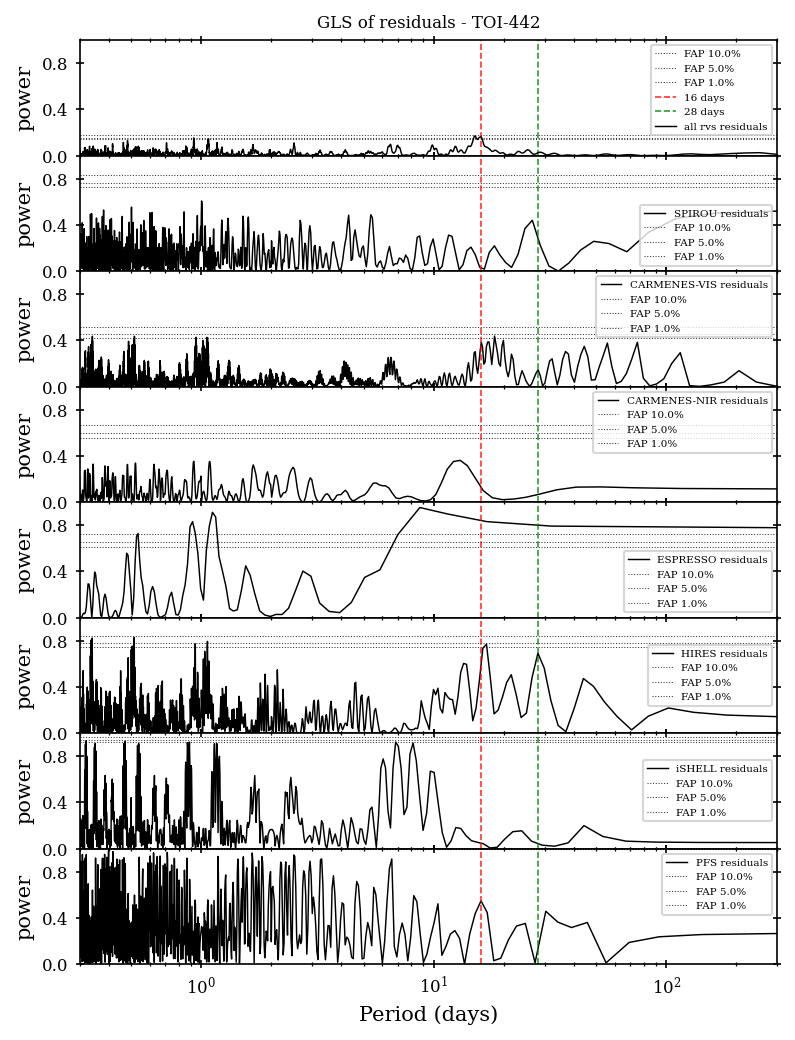

In [333]:
fig, ax = plt.subplots(len(rv_inst_names)+1, 1, figsize=(6, len(rv_inst_names)+1), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0)
lg = ls(x_rv, residuals)
fr, pw = lg.autopower(minimum_frequency=1/300, maximum_frequency=max_freq, samples_per_peak=sppk)
fp = lg.false_alarm_level(probabilities)
ax[0].axhline(y=fp[0], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                  , label=f'FAP {probabilities[0]*100}%', zorder=0)
ax[0].axhline(y=fp[1], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                    , label=f'FAP {probabilities[1]*100}%', zorder=0)
ax[0].axhline(y=fp[2], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                    , label=f'FAP {probabilities[2]*100}%', zorder=0)
ax[0].axvline(16, color='r', linestyle='--', linewidth=0.8, alpha=0.8, label='16 days')
ax[0].axvline(28, color='g', linestyle='--', linewidth=0.8, alpha=0.8, label='28 days')
ax[0].plot(1/fr, pw, color='k', linewidth=0.7, label='all rvs residuals')
ax[0].set_ylabel('power')
ax[0].set_xlim(0.3, 300)
ax[0].set_ylim(0,1)
ax[0].set_xscale('log')
ax[0].legend(fontsize=5)
ax[0].set_title(f'GLS of residuals - {star_name}')
ax[0].set_yticks([0, 0.4, 0.8])
for i, name in enumerate(rv_inst_names):
    m = rv_inst_id == i
    lg = ls(x_rv[m], residuals[m])
    fr, pw = lg.autopower(minimum_frequency=1/300, maximum_frequency=max_freq)
    fp = lg.false_alarm_level(probabilities)
    ax[i+1].plot(1/fr, pw, color='k', linewidth=0.7, label=name+' residuals')
    ax[i+1].axhline(y=fp[0], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                  , label=f'FAP {probabilities[0]*100}%', zorder=0)
    ax[i+1].axhline(y=fp[1], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                    , label=f'FAP {probabilities[1]*100}%', zorder=0)
    ax[i+1].axhline(y=fp[2], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                    , label=f'FAP {probabilities[2]*100}%', zorder=0)
    ax[i+1].set_ylabel('power')
    ax[i+1].legend(fontsize=5)
    ax[i+1].axvline(16., color='r', linestyle='--', linewidth=0.8, alpha=0.8, label='16 days')
    ax[i+1].axvline(28, color='g', linestyle='--', linewidth=0.8, alpha=0.8, label='28 days')
ax[i+1].set_xlabel('Period (days)')
plt.savefig(f'./plots/toi442/rv_residuals_gls_v{version}_{version_names[version]}.png', dpi=200, facecolor='w', bbox_inches='tight')
plt.show()

In [335]:
pm.compute_log_likelihood(trace, model=model)

Output()

TypeError: ("The type's shape ((3,)) is not compatible with the data's ((2,))", 'Container name "trend"')

### LC fit

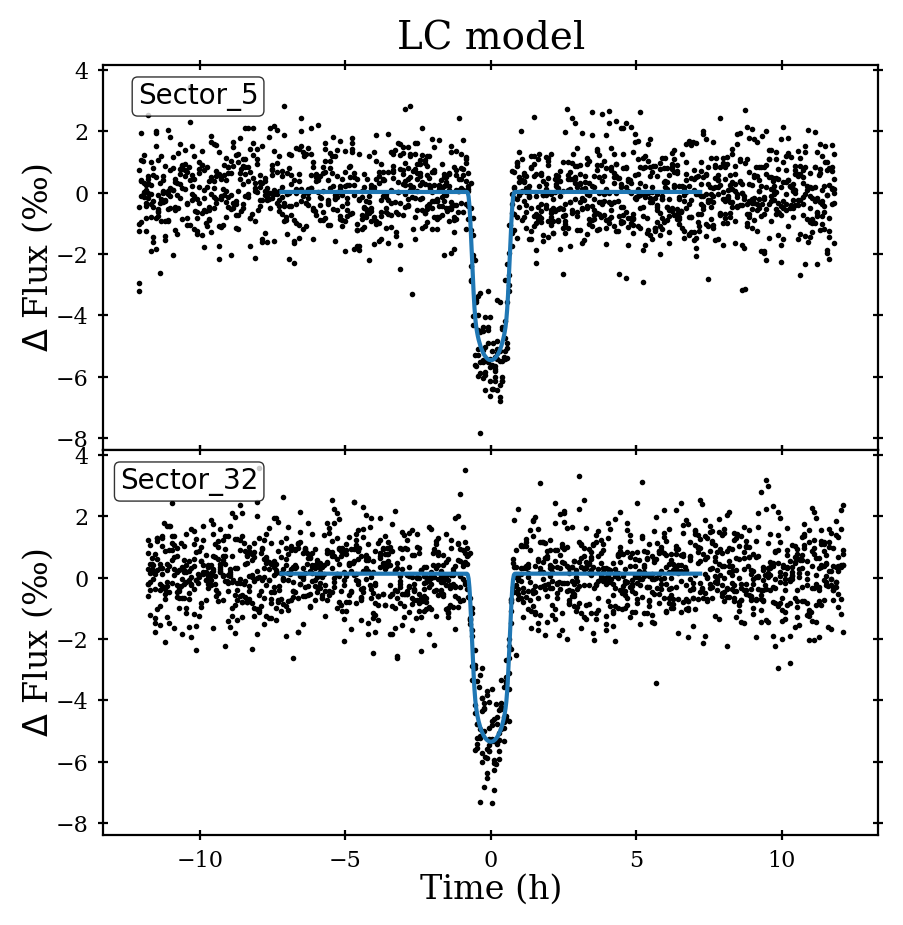

In [243]:
fig, ax = plt.subplots(len(sector_id_names), 1, figsize=(5, 5), sharey=True, sharex=True, dpi=200)
fig.subplots_adjust(hspace=0.)

for i, name in enumerate(sector_id_names):  
    lc = np.median(flat_samps[f"{name}_lc_phase"], axis=-1)  
    gp = np.median(flat_samps[f"{name}_gp_lc_pred"], axis=-1)
    folded_lc = (x[id == i] - t0_ + 0.5 * period) % period - 0.5 * period
    ins = np.argsort(folded_lc)
    ax[i].scatter(folded_lc[ins]*24, y[id == i][ins] - gp[ins], s=1, color='k')
    ax[i].plot(phase_lc*24, lc, label="LC model {}".format(name))
    ax[i].text(x=0.2, y=0.9, s=name, fontsize=10, ha='right', fontweight='normal', fontfamily='sans-serif', 
               bbox=dict(facecolor='white', edgecolor='k', boxstyle='round', pad=0.2, lw=0.5, alpha=0.8), transform=ax[i].transAxes)
    ax[i].set_ylabel(u'$\Delta$ Flux (‰)', fontsize=12, labelpad=0.5)
ax[0].set_title('LC model', fontsize=14)
ax[0].set_ylabel(u'$\Delta$ Flux (‰)', fontsize=12, labelpad=0.5)
ax[0].set_xlim()
ax[i].set_xlabel("Time (h)", fontsize=12, labelpad=0.5)
plt.savefig(f'./plots/toi442/lc_fits_{star_name}_v{version}.png', dpi=200, facecolor='w', bbox_inches='tight')

## Model comparison

Compute the log-likelihood (if not computed during sampling)

In [343]:
pm.compute_log_likelihood(trace, model=model)

Output()

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

Use LOO-CV-PSIS implemented in Arviz

In [344]:
az.loo(trace, var_name='obs')

/home/juan/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 2000 posterior samples and 116 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -440.49    10.41
p_loo       17.46        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      111   95.7%
 (0.5, 0.7]   (ok)          3    2.6%
   (0.7, 1]   (bad)         2    1.7%
   (1, Inf)   (very bad)    0    0.0%

In [345]:
az.waic(trace, var_name='obs')

/home/juan/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 posterior samples and 116 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -439.45    10.19
p_waic       16.42        -

There has been a warning during the calculation. Please check the results.

Compare models

In [ ]:
# az.style.use("arviz-doc")

# model_compare = az.compare(
#     {
#         "Centered 8 schools": az.load_arviz_data("centered_eight"),
#         "Non-centered 8 schools": az.load_arviz_data("non_centered_eight"),
#     }
# )
# az.plot_compare(model_compare, figsize=(11.5, 5))

# plt.show()